In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.colors as color
import matplotlib.cm as cmx
from matplotlib.pyplot import cm
from mpl_toolkits.mplot3d import Axes3D
import time, os, json
from itertools import combinations
import torch
from torch_geometric.utils import from_networkx

'''Data loading'''

file_path = 'C:/Users/Teamaerosal/Desktop/Dissertation DUE 29TH AUG/Essentials for Braille Project/07_03_collect_10_row1_1/events/taps_trial_0_pose_0_events_off.npy'
data = np.load(file_path, allow_pickle = True)
print(data.dtype.names)


#check a single pixel:
for y in range(480):
    for x in range(640):
        if len(data[y][x]) > 0:
            print(f"Pixel ({x}, {y}):", data[y][x])
            break
    else:
        continue
    break
print("The data is an array containing lists. Eaxh pixel has (x,y) values and a [timestamp]") 

None
Pixel (188, 0): [24895]
The data is an array containing lists. Eaxh pixel has (x,y) values and a [timestamp]


In [26]:
#rearrange mapping to time based.

indices = [i for i in np.ndindex(data.shape) if len(data[i]) > 0]

#reverse the mapping:
from collections import defaultdict

#dictionary of timestamps + event indices for values
organized_data = defaultdict(list)

for i in indices:
    for ts in data[i]:
        organized_data[ts].append(i)

#sorted list of timestamps + corresponding coordinates:
sorted_timestamps = sorted(organized_data.keys())
for ts in sorted_timestamps:
    print(f"Timestamp {ts}: Coords {organized_data[ts]}")


Timestamp 10: Coords [(441, 591)]
Timestamp 11: Coords [(441, 591)]
Timestamp 15: Coords [(441, 591)]
Timestamp 20: Coords [(441, 29)]
Timestamp 21: Coords [(441, 29)]
Timestamp 23: Coords [(23, 575), (391, 21)]
Timestamp 33: Coords [(442, 29)]
Timestamp 34: Coords [(441, 29)]
Timestamp 35: Coords [(24, 575), (264, 463)]
Timestamp 36: Coords [(24, 575)]
Timestamp 39: Coords [(442, 29)]
Timestamp 47: Coords [(442, 29)]
Timestamp 49: Coords [(441, 29)]
Timestamp 50: Coords [(441, 29)]
Timestamp 53: Coords [(193, 543)]
Timestamp 60: Coords [(397, 410)]
Timestamp 64: Coords [(294, 93)]
Timestamp 100: Coords [(441, 29)]
Timestamp 129: Coords [(441, 29)]
Timestamp 131: Coords [(442, 29)]
Timestamp 135: Coords [(441, 29)]
Timestamp 141: Coords [(98, 421)]
Timestamp 152: Coords [(442, 29)]
Timestamp 154: Coords [(441, 29)]
Timestamp 161: Coords [(308, 413), (427, 160)]
Timestamp 165: Coords [(427, 160)]
Timestamp 170: Coords [(341, 491)]
Timestamp 172: Coords [(341, 491)]
Timestamp 181: Coords

In [27]:
import pandas as pd

#flatten organized_data into list of dicts
rows = []
for ts, coords in organized_data.items():
    for x, y in coords:
        rows.append({'timestamp': ts, 'x': x, 'y': y})

df = pd.DataFrame(rows)

df_sorted = df.sort_values('timestamp')

#show first few rows
print(df_sorted.head())

#show summary
print(df_sorted.info())

        timestamp    x    y
197517         10  441  591
197518         11  441  591
197519         15  441  591
197176         20  441   29
197177         21  441   29
<class 'pandas.core.frame.DataFrame'>
Index: 205512 entries, 197517 to 32368
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   timestamp  205512 non-null  int64
 1   x          205512 non-null  int64
 2   y          205512 non-null  int64
dtypes: int64(3)
memory usage: 6.3 MB
None


Total data labeling and binning (+ diagrams):

Bin starting at 0ms: 19 coordinates
  Sample coords: [{'timestamp': 10, 'x': 441, 'y': 591}, {'timestamp': 11, 'x': 441, 'y': 591}, {'timestamp': 15, 'x': 441, 'y': 591}]
Bin starting at 100ms: 22 coordinates
  Sample coords: [{'timestamp': 100, 'x': 441, 'y': 29}, {'timestamp': 129, 'x': 441, 'y': 29}, {'timestamp': 131, 'x': 442, 'y': 29}]
Bin starting at 200ms: 38 coordinates
  Sample coords: [{'timestamp': 200, 'x': 71, 'y': 577}, {'timestamp': 201, 'x': 71, 'y': 577}, {'timestamp': 201, 'x': 305, 'y': 410}]
Bin starting at 300ms: 26 coordinates
  Sample coords: [{'timestamp': 300, 'x': 259, 'y': 212}, {'timestamp': 301, 'x': 28, 'y': 15}, {'timestamp': 301, 'x': 442, 'y': 29}]
Bin starting at 400ms: 25 coordinates
  Sample coords: [{'timestamp': 410, 'x': 442, 'y': 29}, {'timestamp': 417, 'x': 427, 'y': 160}, {'timestamp': 418, 'x': 308, 'y': 410}]
Bin 0: 19 Events
Bin 1: 22 Events
Bin 2: 38 Events
Bin 3: 26 Events
Bin 4: 25 Events
Bin 5: 13 Events
Bin 6: 10 Events
Bin 7: 17 Event

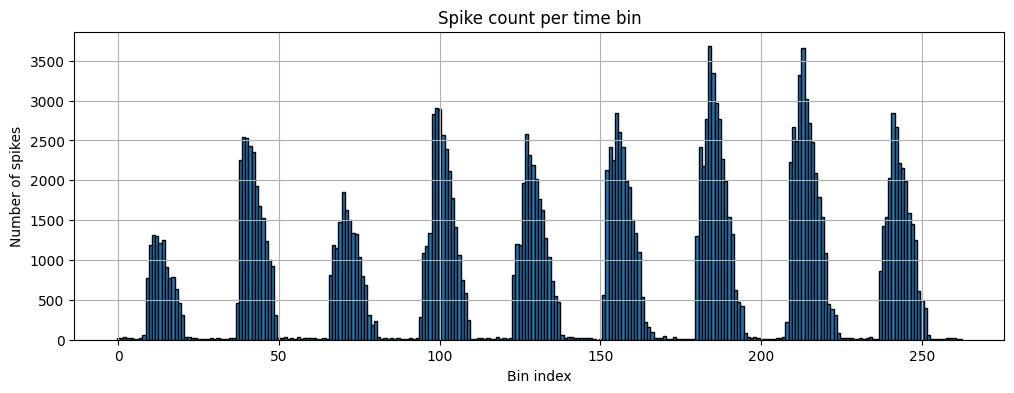

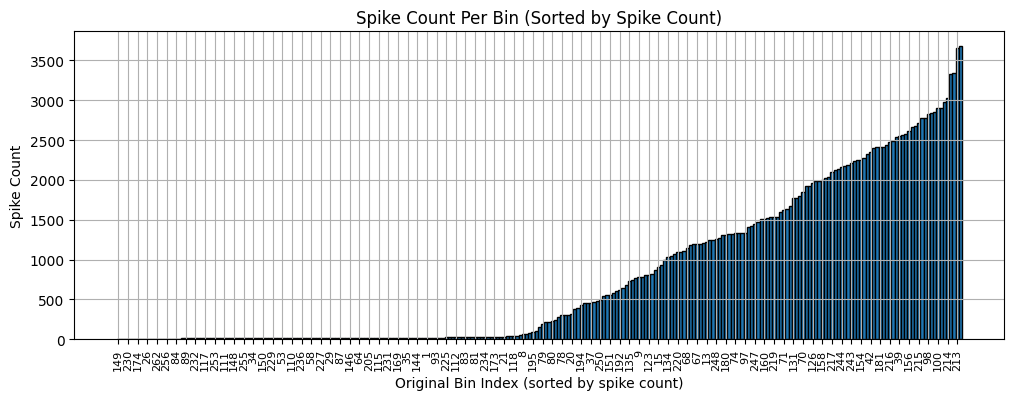

'\nbins = np.arange(14)\ncenters = bins[:-1] + np.diff(bins) / 2\ny = np.sin(centers / 2)\n\nplt.step(bins[:-1], y, where=\'post\', label=\'step(where="post")\')\nplt.plot(bins[:-1], y, \'o--\', color=\'grey\', alpha=0.3)\n\nplt.stairs(y - 1, bins, baseline=None, label=\'stairs()\')\nplt.plot(centers, y - 1, \'o--\', color=\'grey\', alpha=0.3)\nplt.plot(np.repeat(bins, 2), np.hstack([y[0], np.repeat(y, 2), y[-1]]) - 1,\n         \'o\', color=\'red\', alpha=0.2)\n\nplt.legend()\nplt.title(\'step() vs. stairs()\')\nplt.show()\n'

In [28]:
'''Total Data Binning (time-based)'''

from collections import defaultdict

'''Binning:'''

#time_bins = [0.010, 0.050, 0.100]  #time bin lengths(s) - modular bin sizes

bin = 100  #selected bin duration (100ms).

time_bins = defaultdict(list) #dictionary to store binned data

for _, row in df_sorted.iterrows():
    bin_start = (row['timestamp'] // bin) * bin #floor division to find bin start time
    time_bins[bin_start].append({
    'timestamp': row['timestamp'], #store timestamp
    'x': row['x'],
    'y': row['y']
    }) #record cords into bin
        
#view first 5 time bins
for i, (bin_start, coords_list) in enumerate(sorted(time_bins.items())):
    print(f"Bin starting at {bin_start}ms: {len(coords_list)} coordinates")
    print(f"  Sample coords: {coords_list[:3]}")  #show first 3 coords
    if i >= 4:  #stop after 5 bins
        break

#extract features from binned data
import networkx as nx

#extract events
node_features = np.array([len(events) for bin_start, events in sorted(time_bins.items())]).reshape(-1, 1)

for i in range(len(node_features)):
    print(f"Bin {i}: {node_features[i][0]} Events")

event_counts = node_features.flatten()
bins = np.arange(len(event_counts))

G = nx.Graph()
G.add_nodes_from(bins)

'''Bin-ordered:'''

plt.figure(figsize = (12, 4))
plt.bar(np.arange(len(event_counts)), event_counts, width = 1.0, edgecolor = 'black')
plt.xlabel('Bin index')
plt.ylabel('Number of spikes')
plt.title('Spike count per time bin')
plt.grid(True)
plt.show()

'''Spike-count ordered:'''

#pair each bin index with corresponding spike count (excluding 0 events)
bin_spike_pairs = [(i, count) for i, count in enumerate(event_counts) if count > 0]

#sorted by spike-count:
sorted_pairs = sorted(bin_spike_pairs, key = lambda x: x[1])  # (bin_index, spike_count)

#unpack into separate lists
sorted_bins, sorted_counts = zip(*sorted_pairs)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(sorted_counts)), sorted_counts, tick_label = sorted_bins, width = 1.0, edgecolor = 'black')

#space out x ticks (every 3 bars)
xtick_spacing = 3
plt.xticks(
    ticks = np.arange(0, len(sorted_bins), xtick_spacing),
    labels = [sorted_bins[i] for i in range(0, len(sorted_bins), xtick_spacing)],
    rotation = 90,
    fontsize = 8
)

plt.xlabel('Original Bin Index (sorted by spike count)')
plt.ylabel('Spike Count')
plt.title('Spike Count Per Bin (Sorted by Spike Count)')
plt.grid(True)
plt.show()

#what do you mean by staircase plot?
#attempt:
'''
#plot staircase
plt.figure(figsize=(10, 4))
plt.stairs(event_counts, edges=np.arange(len(event_counts) + 1), fill=True)
plt.xlabel("Bin Index")
plt.ylabel("Spike Count")
plt.title("Spike Count Per Bin (Stairs Plot)")
plt.grid(True)
plt.show()
'''

#example for staircase plot
'''
bins = np.arange(14)
centers = bins[:-1] + np.diff(bins) / 2
y = np.sin(centers / 2)

plt.step(bins[:-1], y, where='post', label='step(where="post")')
plt.plot(bins[:-1], y, 'o--', color='grey', alpha=0.3)

plt.stairs(y - 1, bins, baseline=None, label='stairs()')
plt.plot(centers, y - 1, 'o--', color='grey', alpha=0.3)
plt.plot(np.repeat(bins, 2), np.hstack([y[0], np.repeat(y, 2), y[-1]]) - 1,
         'o', color='red', alpha=0.2)

plt.legend()
plt.title('step() vs. stairs()')
plt.show()
'''

Letter based labeling and binning (+ diagrams):


===== Letter A =====
Bin starting at 10ms: 3 coordinates
  Sample coords: [{'timestamp': 10, 'x': 441, 'y': 591}, {'timestamp': 11, 'x': 441, 'y': 591}, {'timestamp': 15, 'x': 441, 'y': 591}]
Bin starting at 20ms: 4 coordinates
  Sample coords: [{'timestamp': 20, 'x': 441, 'y': 29}, {'timestamp': 21, 'x': 441, 'y': 29}, {'timestamp': 23, 'x': 23, 'y': 575}]
Bin starting at 30ms: 6 coordinates
  Sample coords: [{'timestamp': 33, 'x': 442, 'y': 29}, {'timestamp': 34, 'x': 441, 'y': 29}, {'timestamp': 35, 'x': 264, 'y': 463}]
Bin starting at 40ms: 2 coordinates
  Sample coords: [{'timestamp': 47, 'x': 442, 'y': 29}, {'timestamp': 49, 'x': 441, 'y': 29}]
Bin starting at 50ms: 2 coordinates
  Sample coords: [{'timestamp': 50, 'x': 441, 'y': 29}, {'timestamp': 53, 'x': 193, 'y': 543}]
Bin 0: 3 Events
Bin 1: 4 Events
Bin 2: 6 Events
Bin 3: 2 Events
Bin 4: 2 Events
Bin 5: 2 Events
Bin 6: 1 Events
Bin 7: 1 Events
Bin 8: 2 Events
Bin 9: 1 Events
Bin 10: 2 Events
Bin 11: 3 Events
Bin 12: 2 Event

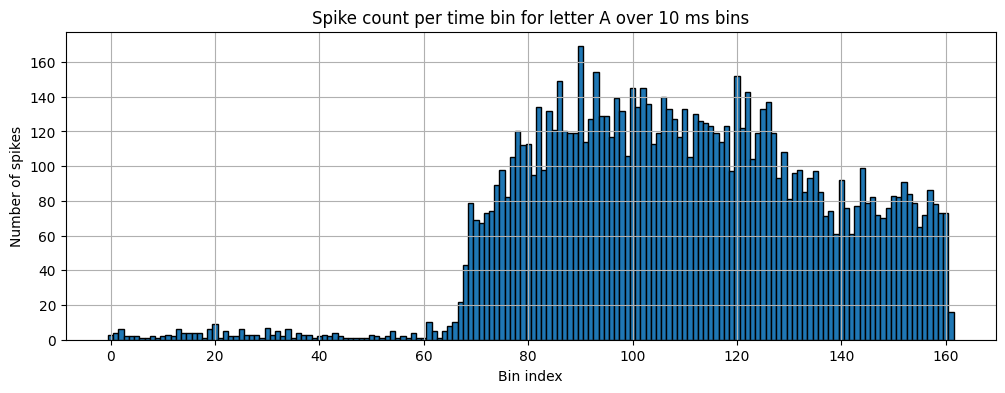

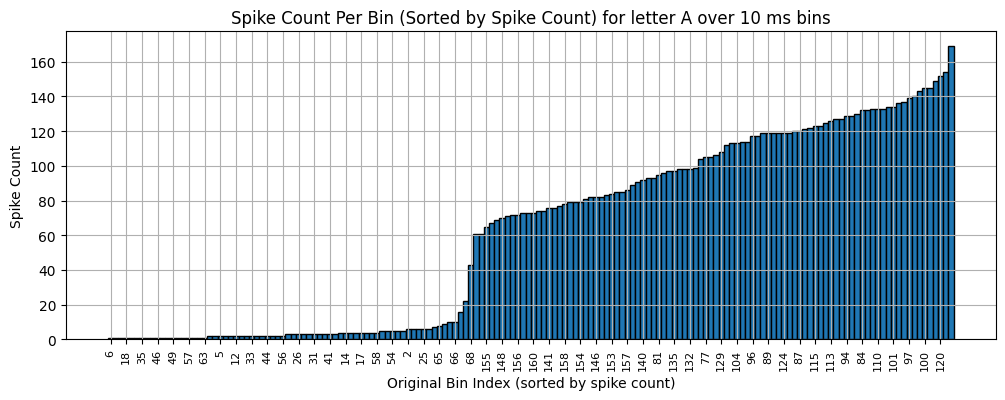


===== Letter B =====
Bin starting at 1830ms: 51 coordinates
  Sample coords: [{'timestamp': 1832, 'x': 94, 'y': 442}, {'timestamp': 1833, 'x': 106, 'y': 459}, {'timestamp': 1834, 'x': 94, 'y': 445}]
Bin starting at 1840ms: 63 coordinates
  Sample coords: [{'timestamp': 1840, 'x': 87, 'y': 439}, {'timestamp': 1840, 'x': 82, 'y': 436}, {'timestamp': 1841, 'x': 101, 'y': 443}]
Bin starting at 1850ms: 59 coordinates
  Sample coords: [{'timestamp': 1850, 'x': 93, 'y': 441}, {'timestamp': 1850, 'x': 95, 'y': 456}, {'timestamp': 1850, 'x': 98, 'y': 446}]
Bin starting at 1860ms: 52 coordinates
  Sample coords: [{'timestamp': 1860, 'x': 101, 'y': 436}, {'timestamp': 1860, 'x': 98, 'y': 452}, {'timestamp': 1860, 'x': 81, 'y': 436}]
Bin starting at 1870ms: 58 coordinates
  Sample coords: [{'timestamp': 1870, 'x': 81, 'y': 435}, {'timestamp': 1870, 'x': 82, 'y': 446}, {'timestamp': 1870, 'x': 88, 'y': 454}]
Bin 0: 51 Events
Bin 1: 63 Events
Bin 2: 59 Events
Bin 3: 52 Events
Bin 4: 58 Events
Bin 5

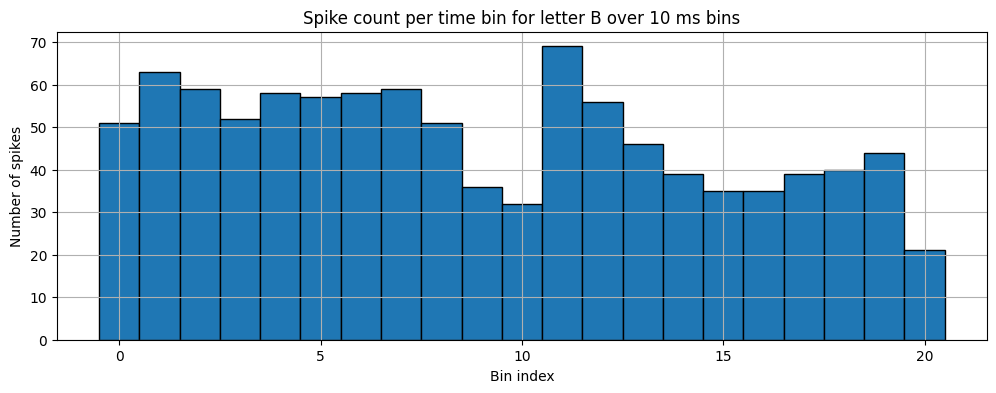

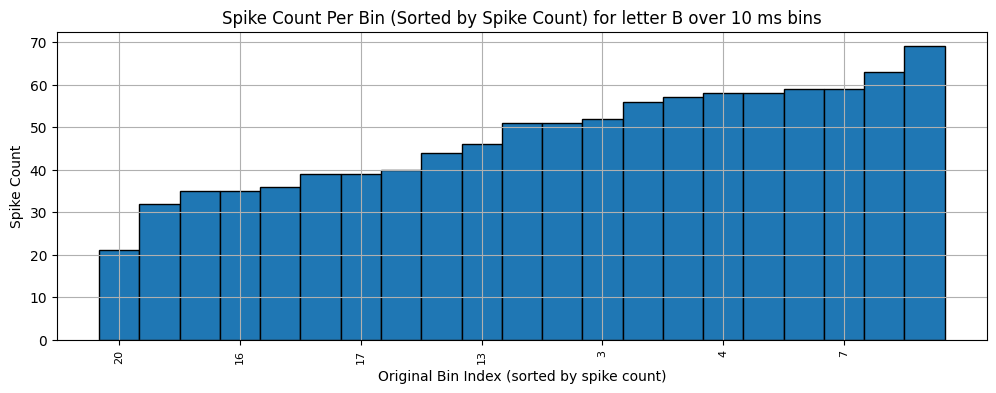


===== Letter C =====
Bin starting at 2030ms: 22 coordinates
  Sample coords: [{'timestamp': 2035, 'x': 17, 'y': 430}, {'timestamp': 2035, 'x': 16, 'y': 13}, {'timestamp': 2035, 'x': 19, 'y': 435}]
Bin starting at 2040ms: 44 coordinates
  Sample coords: [{'timestamp': 2040, 'x': 15, 'y': 435}, {'timestamp': 2040, 'x': 14, 'y': 438}, {'timestamp': 2040, 'x': 3, 'y': 439}]
Bin starting at 2050ms: 27 coordinates
  Sample coords: [{'timestamp': 2050, 'x': 24, 'y': 460}, {'timestamp': 2050, 'x': 377, 'y': 450}, {'timestamp': 2050, 'x': 13, 'y': 450}]
Bin starting at 2060ms: 26 coordinates
  Sample coords: [{'timestamp': 2060, 'x': 8, 'y': 440}, {'timestamp': 2061, 'x': 3, 'y': 444}, {'timestamp': 2061, 'x': 5, 'y': 402}]
Bin starting at 2070ms: 31 coordinates
  Sample coords: [{'timestamp': 2070, 'x': 3, 'y': 434}, {'timestamp': 2070, 'x': 0, 'y': 438}, {'timestamp': 2070, 'x': 4, 'y': 443}]
Bin 0: 22 Events
Bin 1: 44 Events
Bin 2: 27 Events
Bin 3: 26 Events
Bin 4: 31 Events
Bin 5: 13 Event

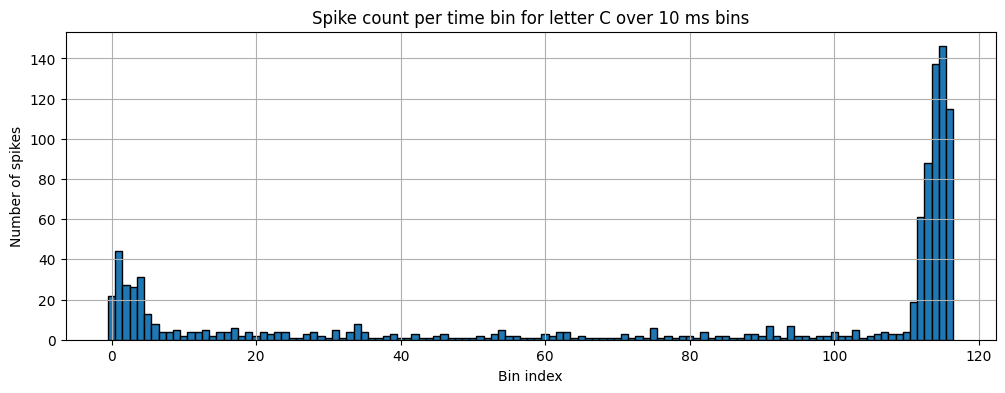

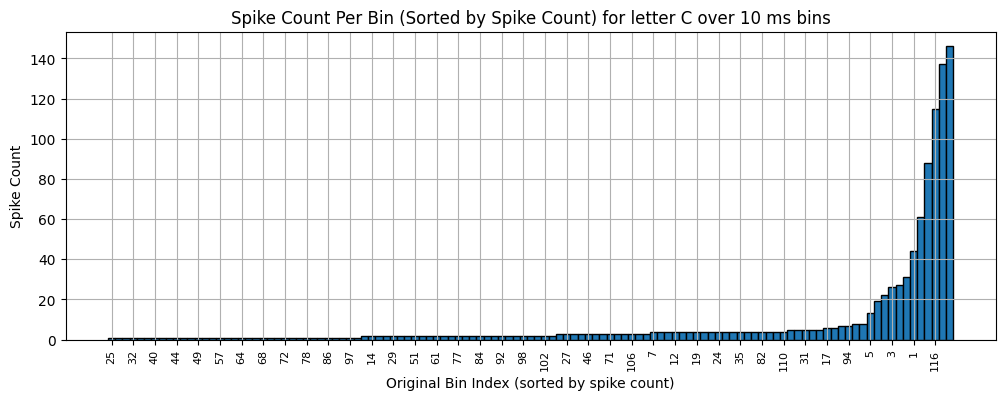


===== Letter D =====
Bin starting at 3800ms: 25 coordinates
  Sample coords: [{'timestamp': 3808, 'x': 468, 'y': 289}, {'timestamp': 3809, 'x': 457, 'y': 425}, {'timestamp': 3809, 'x': 458, 'y': 298}]
Bin starting at 3810ms: 192 coordinates
  Sample coords: [{'timestamp': 3810, 'x': 456, 'y': 305}, {'timestamp': 3810, 'x': 470, 'y': 313}, {'timestamp': 3810, 'x': 470, 'y': 289}]
Bin starting at 3820ms: 203 coordinates
  Sample coords: [{'timestamp': 3820, 'x': 454, 'y': 292}, {'timestamp': 3820, 'x': 460, 'y': 307}, {'timestamp': 3820, 'x': 459, 'y': 430}]
Bin starting at 3830ms: 244 coordinates
  Sample coords: [{'timestamp': 3830, 'x': 471, 'y': 448}, {'timestamp': 3830, 'x': 461, 'y': 430}, {'timestamp': 3830, 'x': 459, 'y': 303}]
Bin starting at 3840ms: 243 coordinates
  Sample coords: [{'timestamp': 3840, 'x': 461, 'y': 290}, {'timestamp': 3840, 'x': 458, 'y': 438}, {'timestamp': 3840, 'x': 457, 'y': 293}]
Bin 0: 25 Events
Bin 1: 192 Events
Bin 2: 203 Events
Bin 3: 244 Events
Bin

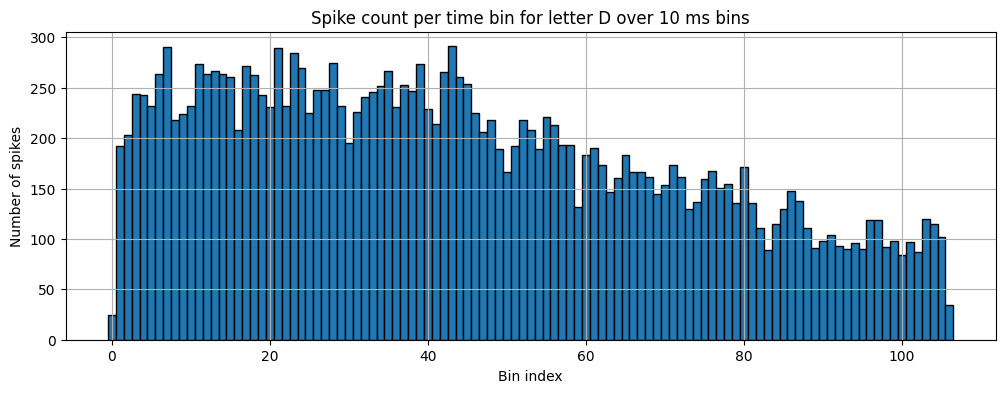

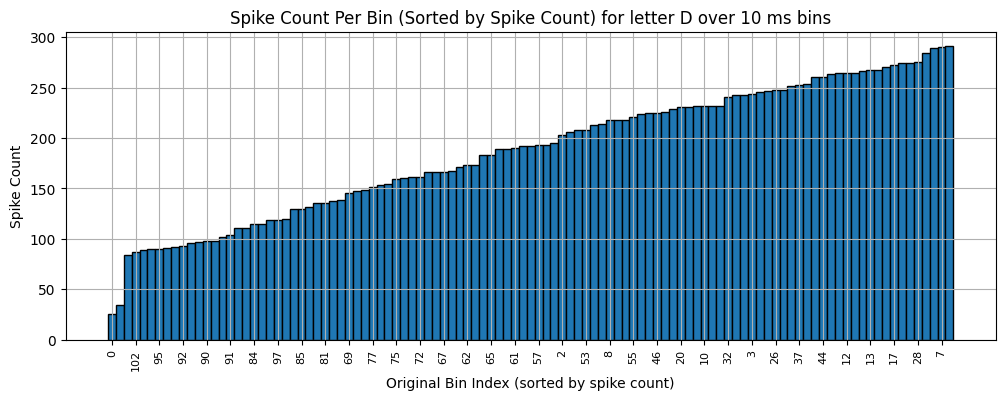


===== Letter E =====
Bin starting at 4860ms: 42 coordinates
  Sample coords: [{'timestamp': 4864, 'x': 29, 'y': 415}, {'timestamp': 4864, 'x': 31, 'y': 414}, {'timestamp': 4864, 'x': 37, 'y': 277}]
Bin starting at 4870ms: 80 coordinates
  Sample coords: [{'timestamp': 4870, 'x': 26, 'y': 287}, {'timestamp': 4870, 'x': 24, 'y': 417}, {'timestamp': 4870, 'x': 25, 'y': 415}]
Bin starting at 4880ms: 97 coordinates
  Sample coords: [{'timestamp': 4880, 'x': 24, 'y': 284}, {'timestamp': 4880, 'x': 14, 'y': 276}, {'timestamp': 4880, 'x': 15, 'y': 275}]
Bin starting at 4890ms: 71 coordinates
  Sample coords: [{'timestamp': 4890, 'x': 19, 'y': 436}, {'timestamp': 4890, 'x': 16, 'y': 280}, {'timestamp': 4890, 'x': 21, 'y': 425}]
Bin starting at 4900ms: 102 coordinates
  Sample coords: [{'timestamp': 4900, 'x': 13, 'y': 294}, {'timestamp': 4900, 'x': 15, 'y': 278}, {'timestamp': 4900, 'x': 12, 'y': 283}]
Bin 0: 42 Events
Bin 1: 80 Events
Bin 2: 97 Events
Bin 3: 71 Events
Bin 4: 102 Events
Bin 5:

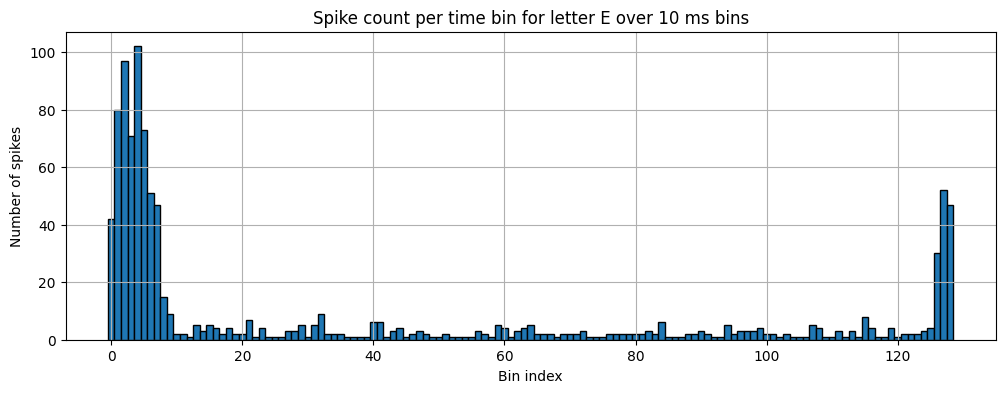

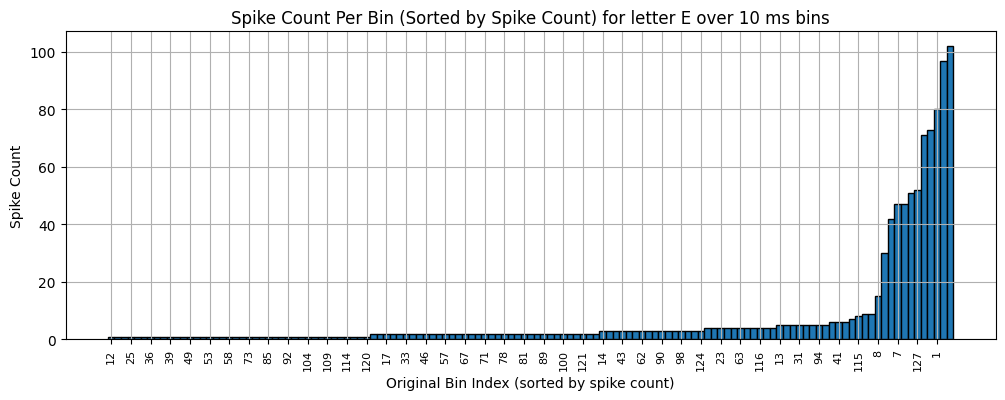


===== Letter F =====
Bin starting at 6620ms: 17 coordinates
  Sample coords: [{'timestamp': 6627, 'x': 476, 'y': 423}, {'timestamp': 6628, 'x': 474, 'y': 410}, {'timestamp': 6628, 'x': 475, 'y': 418}]
Bin starting at 6630ms: 92 coordinates
  Sample coords: [{'timestamp': 6630, 'x': 477, 'y': 402}, {'timestamp': 6630, 'x': 471, 'y': 404}, {'timestamp': 6630, 'x': 477, 'y': 422}]
Bin starting at 6640ms: 85 coordinates
  Sample coords: [{'timestamp': 6640, 'x': 475, 'y': 419}, {'timestamp': 6640, 'x': 473, 'y': 435}, {'timestamp': 6640, 'x': 465, 'y': 418}]
Bin starting at 6650ms: 97 coordinates
  Sample coords: [{'timestamp': 6650, 'x': 456, 'y': 406}, {'timestamp': 6650, 'x': 460, 'y': 409}, {'timestamp': 6650, 'x': 478, 'y': 401}]
Bin starting at 6660ms: 74 coordinates
  Sample coords: [{'timestamp': 6660, 'x': 454, 'y': 426}, {'timestamp': 6660, 'x': 455, 'y': 404}, {'timestamp': 6660, 'x': 458, 'y': 418}]
Bin 0: 17 Events
Bin 1: 92 Events
Bin 2: 85 Events
Bin 3: 97 Events
Bin 4: 74 

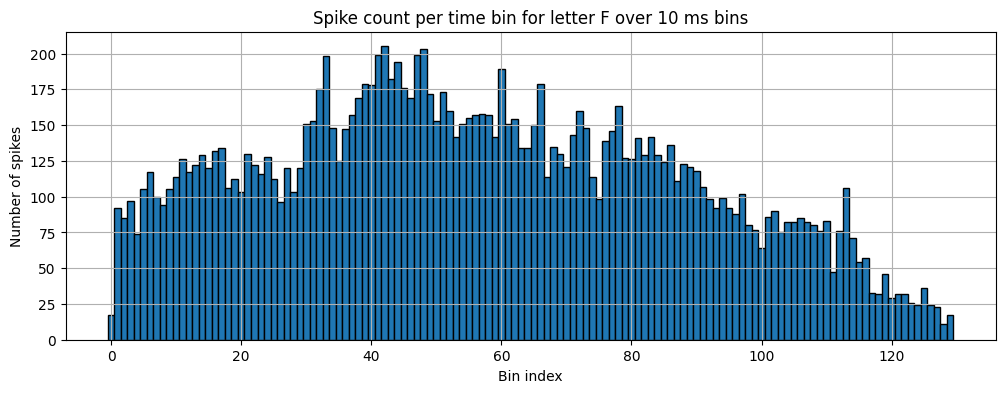

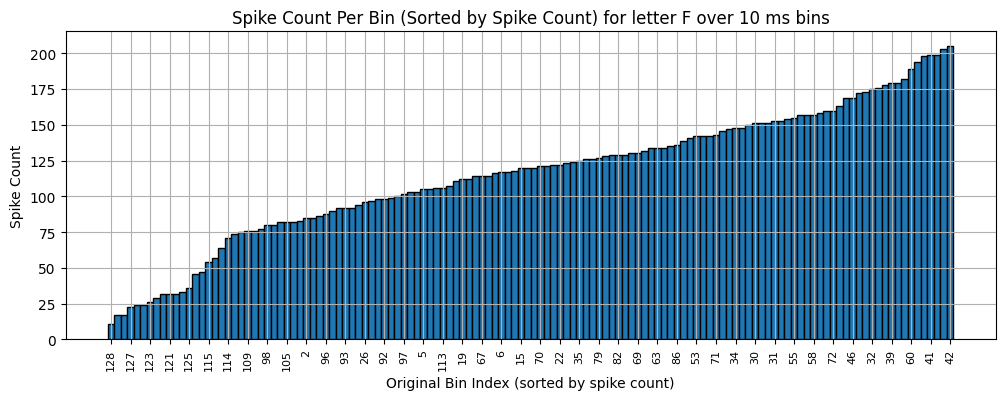


===== Letter G =====
Bin starting at 7910ms: 1 coordinates
  Sample coords: [{'timestamp': 7919, 'x': 79, 'y': 402}]
Bin starting at 7920ms: 18 coordinates
  Sample coords: [{'timestamp': 7920, 'x': 354, 'y': 450}, {'timestamp': 7921, 'x': 65, 'y': 401}, {'timestamp': 7921, 'x': 81, 'y': 402}]
Bin starting at 7930ms: 26 coordinates
  Sample coords: [{'timestamp': 7930, 'x': 66, 'y': 402}, {'timestamp': 7931, 'x': 71, 'y': 577}, {'timestamp': 7931, 'x': 68, 'y': 402}]
Bin starting at 7940ms: 24 coordinates
  Sample coords: [{'timestamp': 7940, 'x': 60, 'y': 407}, {'timestamp': 7940, 'x': 70, 'y': 405}, {'timestamp': 7940, 'x': 63, 'y': 406}]
Bin starting at 7950ms: 18 coordinates
  Sample coords: [{'timestamp': 7951, 'x': 60, 'y': 397}, {'timestamp': 7951, 'x': 61, 'y': 406}, {'timestamp': 7951, 'x': 78, 'y': 390}]
Bin 0: 1 Events
Bin 1: 18 Events
Bin 2: 26 Events
Bin 3: 24 Events
Bin 4: 18 Events
Bin 5: 16 Events
Bin 6: 24 Events
Bin 7: 14 Events
Bin 8: 20 Events
Bin 9: 18 Events
Bin 

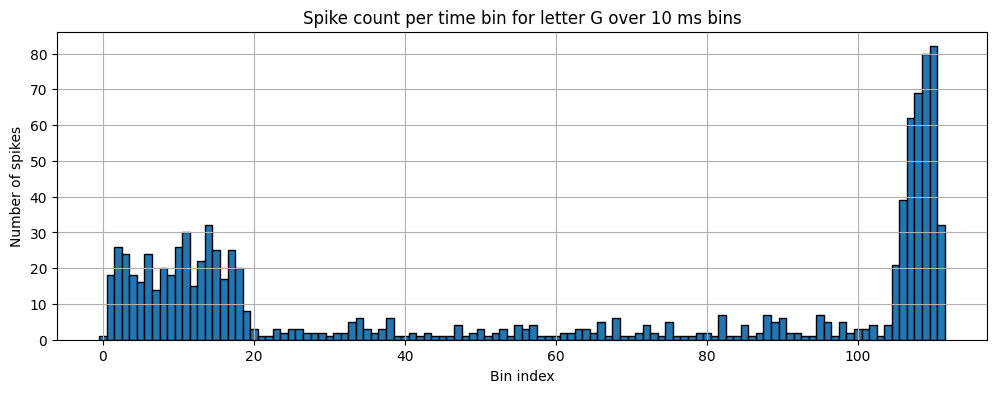

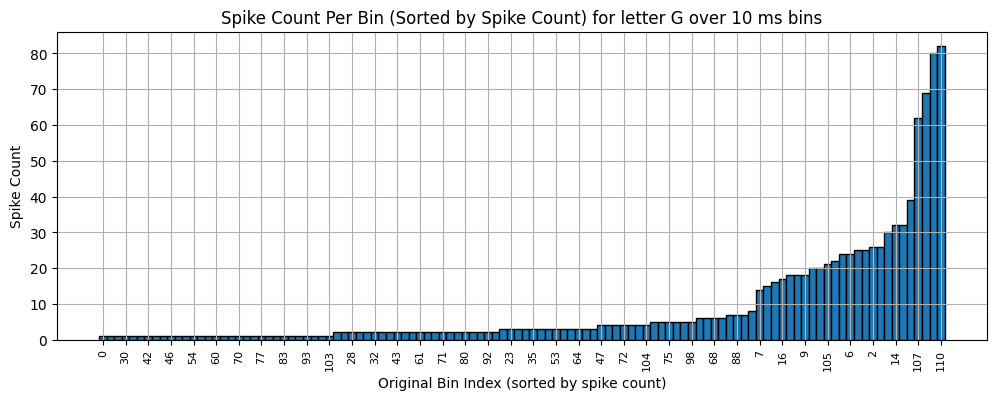


===== Letter H =====
Bin starting at 9510ms: 60 coordinates
  Sample coords: [{'timestamp': 9513, 'x': 468, 'y': 400}, {'timestamp': 9513, 'x': 453, 'y': 394}, {'timestamp': 9513, 'x': 460, 'y': 389}]
Bin starting at 9520ms: 80 coordinates
  Sample coords: [{'timestamp': 9520, 'x': 461, 'y': 396}, {'timestamp': 9520, 'x': 460, 'y': 405}, {'timestamp': 9520, 'x': 458, 'y': 400}]
Bin starting at 9530ms: 83 coordinates
  Sample coords: [{'timestamp': 9530, 'x': 464, 'y': 401}, {'timestamp': 9530, 'x': 470, 'y': 380}, {'timestamp': 9530, 'x': 453, 'y': 397}]
Bin starting at 9540ms: 116 coordinates
  Sample coords: [{'timestamp': 9540, 'x': 452, 'y': 395}, {'timestamp': 9540, 'x': 445, 'y': 382}, {'timestamp': 9540, 'x': 445, 'y': 397}]
Bin starting at 9550ms: 112 coordinates
  Sample coords: [{'timestamp': 9550, 'x': 440, 'y': 383}, {'timestamp': 9550, 'x': 446, 'y': 398}, {'timestamp': 9550, 'x': 444, 'y': 407}]
Bin 0: 60 Events
Bin 1: 80 Events
Bin 2: 83 Events
Bin 3: 116 Events
Bin 4: 

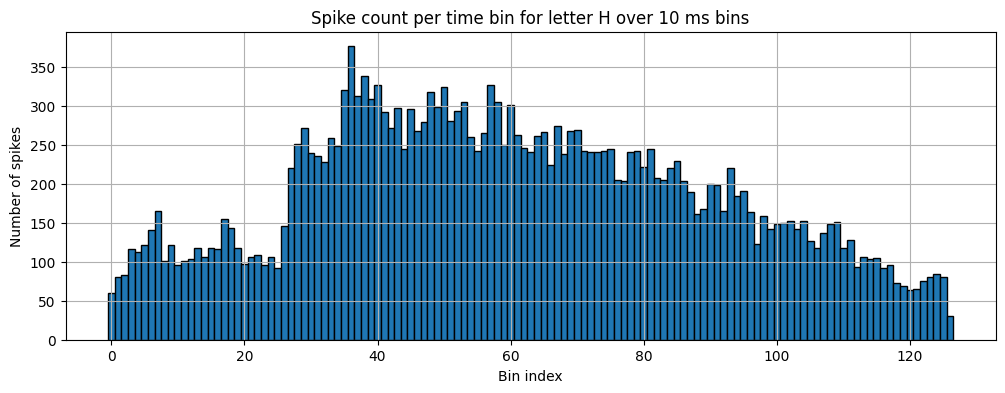

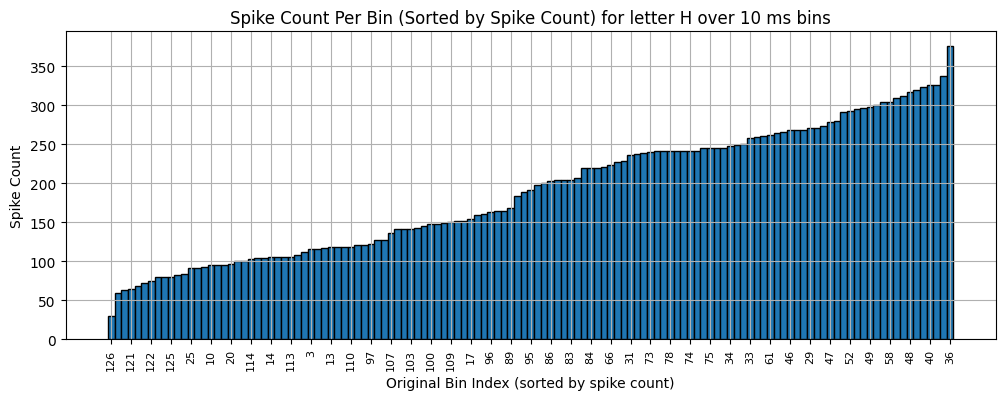


===== Letter I =====
Bin starting at 10770ms: 57 coordinates
  Sample coords: [{'timestamp': 10773, 'x': 58, 'y': 245}, {'timestamp': 10773, 'x': 73, 'y': 384}, {'timestamp': 10773, 'x': 75, 'y': 260}]
Bin starting at 10780ms: 78 coordinates
  Sample coords: [{'timestamp': 10780, 'x': 69, 'y': 384}, {'timestamp': 10780, 'x': 68, 'y': 262}, {'timestamp': 10780, 'x': 68, 'y': 245}]
Bin starting at 10790ms: 65 coordinates
  Sample coords: [{'timestamp': 10790, 'x': 66, 'y': 378}, {'timestamp': 10790, 'x': 63, 'y': 253}, {'timestamp': 10790, 'x': 59, 'y': 376}]
Bin starting at 10800ms: 75 coordinates
  Sample coords: [{'timestamp': 10800, 'x': 66, 'y': 388}, {'timestamp': 10800, 'x': 61, 'y': 245}, {'timestamp': 10800, 'x': 57, 'y': 249}]
Bin starting at 10810ms: 51 coordinates
  Sample coords: [{'timestamp': 10810, 'x': 55, 'y': 250}, {'timestamp': 10810, 'x': 58, 'y': 261}, {'timestamp': 10811, 'x': 63, 'y': 381}]
Bin 0: 57 Events
Bin 1: 78 Events
Bin 2: 65 Events
Bin 3: 75 Events
Bin 4

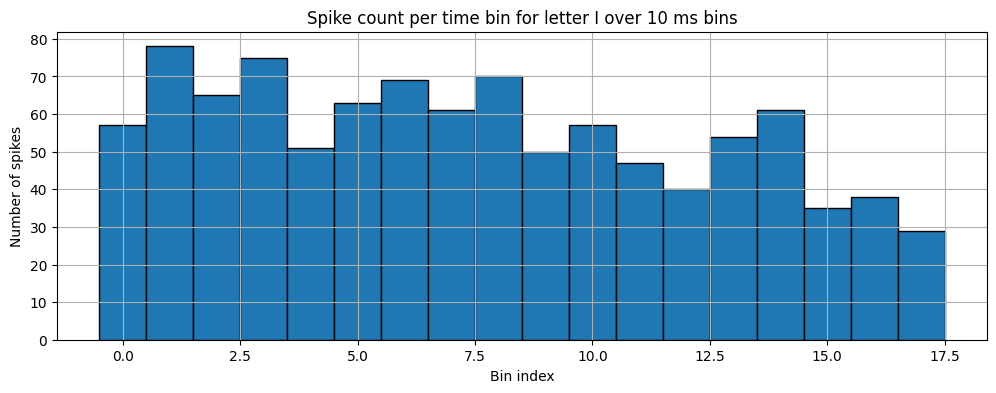

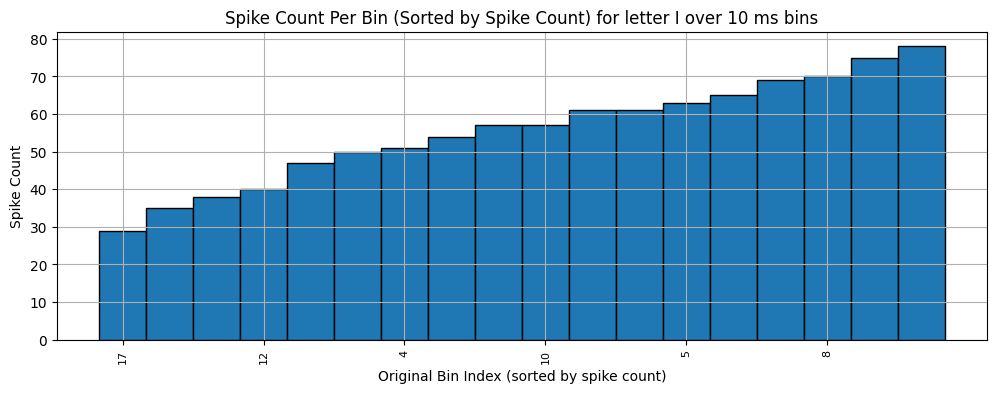


===== Letter J =====
Bin starting at 10940ms: 3 coordinates
  Sample coords: [{'timestamp': 10948, 'x': 0, 'y': 247}, {'timestamp': 10948, 'x': 463, 'y': 414}, {'timestamp': 10949, 'x': 72, 'y': 507}]
Bin starting at 10950ms: 10 coordinates
  Sample coords: [{'timestamp': 10950, 'x': 38, 'y': 225}, {'timestamp': 10952, 'x': 9, 'y': 263}, {'timestamp': 10954, 'x': 1, 'y': 250}]
Bin starting at 10960ms: 8 coordinates
  Sample coords: [{'timestamp': 10962, 'x': 0, 'y': 385}, {'timestamp': 10963, 'x': 71, 'y': 577}, {'timestamp': 10965, 'x': 442, 'y': 29}]
Bin starting at 10970ms: 2 coordinates
  Sample coords: [{'timestamp': 10972, 'x': 71, 'y': 577}, {'timestamp': 10979, 'x': 28, 'y': 15}]
Bin starting at 10980ms: 1 coordinates
  Sample coords: [{'timestamp': 10984, 'x': 17, 'y': 13}]
Bin 0: 3 Events
Bin 1: 10 Events
Bin 2: 8 Events
Bin 3: 2 Events
Bin 4: 1 Events
Bin 5: 4 Events
Bin 6: 2 Events
Bin 7: 2 Events
Bin 8: 1 Events
Bin 9: 2 Events
Bin 10: 1 Events
Bin 11: 2 Events
Bin 12: 2 

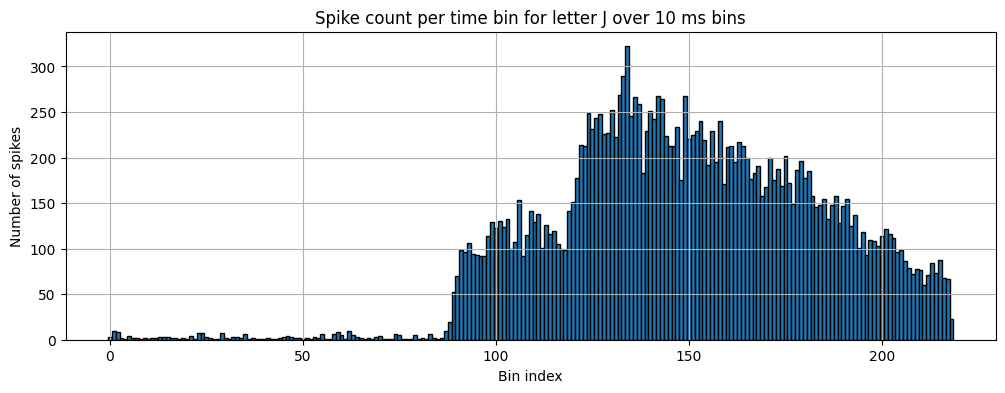

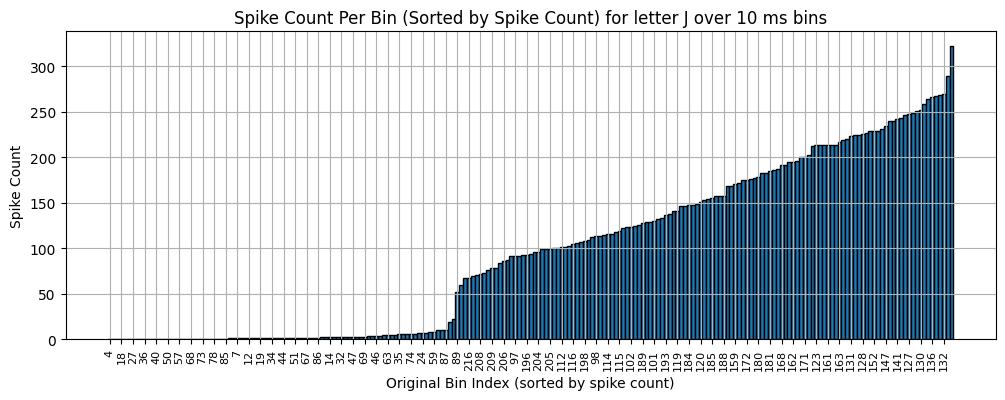


===== Letter Letter_10 =====
Bin starting at 13600ms: 46 coordinates
  Sample coords: [{'timestamp': 13603, 'x': 76, 'y': 241}, {'timestamp': 13604, 'x': 86, 'y': 242}, {'timestamp': 13604, 'x': 77, 'y': 236}]
Bin starting at 13610ms: 74 coordinates
  Sample coords: [{'timestamp': 13610, 'x': 70, 'y': 247}, {'timestamp': 13610, 'x': 72, 'y': 234}, {'timestamp': 13610, 'x': 86, 'y': 251}]
Bin starting at 13620ms: 65 coordinates
  Sample coords: [{'timestamp': 13620, 'x': 66, 'y': 237}, {'timestamp': 13620, 'x': 72, 'y': 242}, {'timestamp': 13620, 'x': 73, 'y': 238}]
Bin starting at 13630ms: 55 coordinates
  Sample coords: [{'timestamp': 13630, 'x': 68, 'y': 252}, {'timestamp': 13630, 'x': 71, 'y': 250}, {'timestamp': 13630, 'x': 68, 'y': 235}]
Bin starting at 13640ms: 56 coordinates
  Sample coords: [{'timestamp': 13640, 'x': 78, 'y': 249}, {'timestamp': 13640, 'x': 61, 'y': 236}, {'timestamp': 13640, 'x': 57, 'y': 236}]
Bin 0: 46 Events
Bin 1: 74 Events
Bin 2: 65 Events
Bin 3: 55 Even

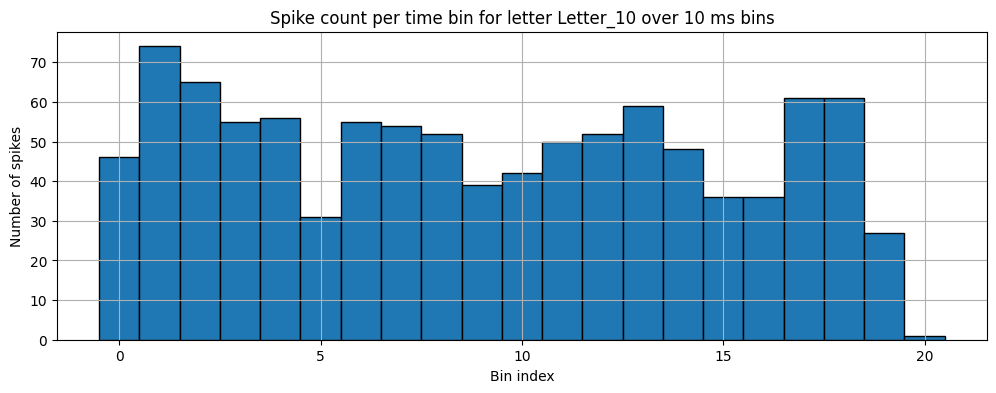

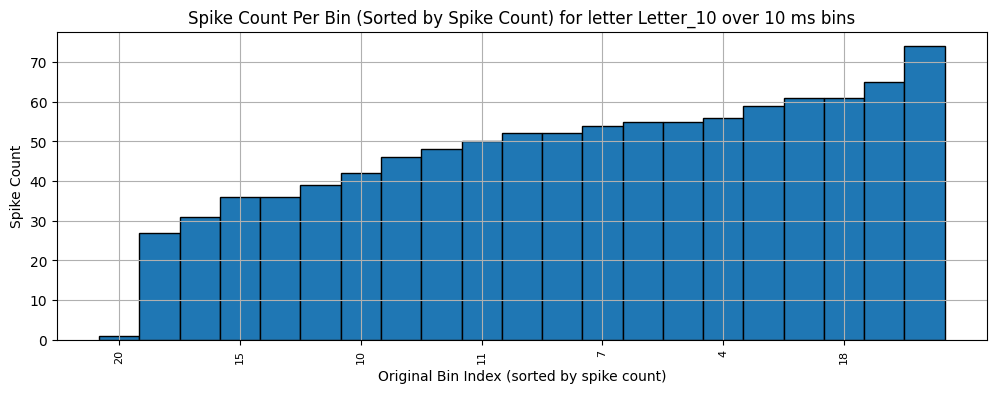


===== Letter Letter_11 =====
Bin starting at 13800ms: 21 coordinates
  Sample coords: [{'timestamp': 13800, 'x': 1, 'y': 235}, {'timestamp': 13800, 'x': 3, 'y': 231}, {'timestamp': 13801, 'x': 2, 'y': 231}]
Bin starting at 13810ms: 12 coordinates
  Sample coords: [{'timestamp': 13810, 'x': 5, 'y': 238}, {'timestamp': 13811, 'x': 442, 'y': 29}, {'timestamp': 13811, 'x': 68, 'y': 368}]
Bin starting at 13820ms: 3 coordinates
  Sample coords: [{'timestamp': 13821, 'x': 0, 'y': 249}, {'timestamp': 13822, 'x': 4, 'y': 239}, {'timestamp': 13822, 'x': 2, 'y': 251}]
Bin starting at 13830ms: 4 coordinates
  Sample coords: [{'timestamp': 13832, 'x': 427, 'y': 160}, {'timestamp': 13835, 'x': 308, 'y': 410}, {'timestamp': 13837, 'x': 427, 'y': 160}]
Bin starting at 13840ms: 1 coordinates
  Sample coords: [{'timestamp': 13843, 'x': 427, 'y': 160}]
Bin 0: 21 Events
Bin 1: 12 Events
Bin 2: 3 Events
Bin 3: 4 Events
Bin 4: 1 Events
Bin 5: 5 Events
Bin 6: 5 Events
Bin 7: 7 Events
Bin 8: 1 Events
Bin 9: 

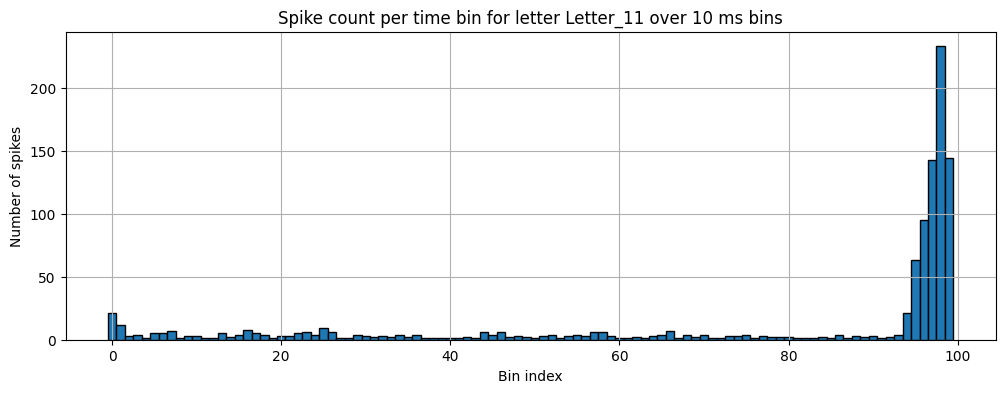

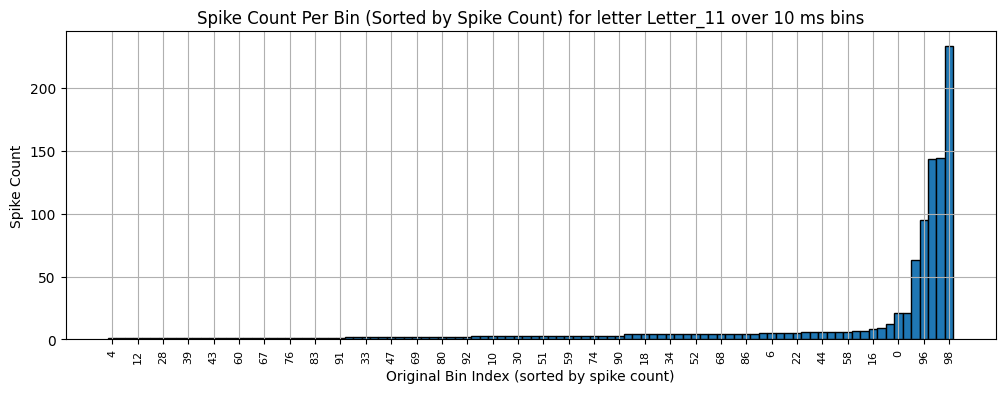


===== Letter Letter_12 =====
Bin starting at 15200ms: 69 coordinates
  Sample coords: [{'timestamp': 15206, 'x': 466, 'y': 239}, {'timestamp': 15206, 'x': 472, 'y': 357}, {'timestamp': 15206, 'x': 465, 'y': 236}]
Bin starting at 15210ms: 199 coordinates
  Sample coords: [{'timestamp': 15210, 'x': 458, 'y': 379}, {'timestamp': 15210, 'x': 459, 'y': 364}, {'timestamp': 15210, 'x': 460, 'y': 234}]
Bin starting at 15220ms: 177 coordinates
  Sample coords: [{'timestamp': 15220, 'x': 459, 'y': 370}, {'timestamp': 15220, 'x': 459, 'y': 252}, {'timestamp': 15220, 'x': 458, 'y': 254}]
Bin starting at 15230ms: 175 coordinates
  Sample coords: [{'timestamp': 15230, 'x': 476, 'y': 349}, {'timestamp': 15230, 'x': 465, 'y': 379}, {'timestamp': 15230, 'x': 465, 'y': 230}]
Bin starting at 15240ms: 224 coordinates
  Sample coords: [{'timestamp': 15240, 'x': 455, 'y': 367}, {'timestamp': 15240, 'x': 457, 'y': 379}, {'timestamp': 15240, 'x': 459, 'y': 368}]
Bin 0: 69 Events
Bin 1: 199 Events
Bin 2: 177 

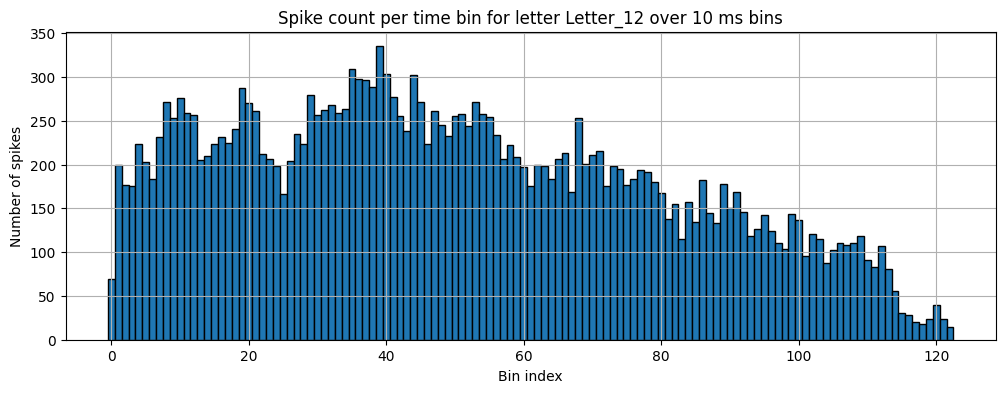

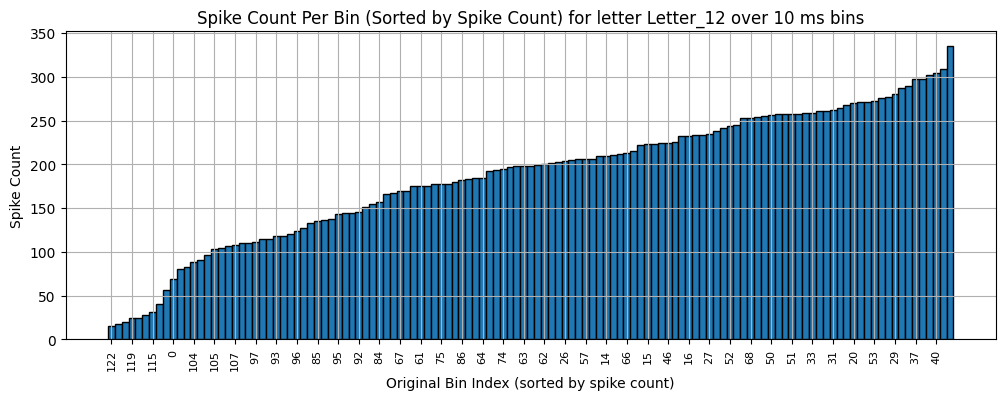


===== Letter Letter_13 =====
Bin starting at 16420ms: 10 coordinates
  Sample coords: [{'timestamp': 16428, 'x': 142, 'y': 360}, {'timestamp': 16428, 'x': 98, 'y': 361}, {'timestamp': 16428, 'x': 95, 'y': 351}]
Bin starting at 16430ms: 25 coordinates
  Sample coords: [{'timestamp': 16431, 'x': 71, 'y': 577}, {'timestamp': 16431, 'x': 142, 'y': 360}, {'timestamp': 16431, 'x': 72, 'y': 576}]
Bin starting at 16440ms: 21 coordinates
  Sample coords: [{'timestamp': 16440, 'x': 71, 'y': 577}, {'timestamp': 16440, 'x': 93, 'y': 360}, {'timestamp': 16440, 'x': 441, 'y': 29}]
Bin starting at 16450ms: 19 coordinates
  Sample coords: [{'timestamp': 16450, 'x': 86, 'y': 353}, {'timestamp': 16450, 'x': 81, 'y': 354}, {'timestamp': 16450, 'x': 88, 'y': 362}]
Bin starting at 16460ms: 9 coordinates
  Sample coords: [{'timestamp': 16460, 'x': 72, 'y': 355}, {'timestamp': 16461, 'x': 88, 'y': 357}, {'timestamp': 16462, 'x': 74, 'y': 354}]
Bin 0: 10 Events
Bin 1: 25 Events
Bin 2: 21 Events
Bin 3: 19 Eve

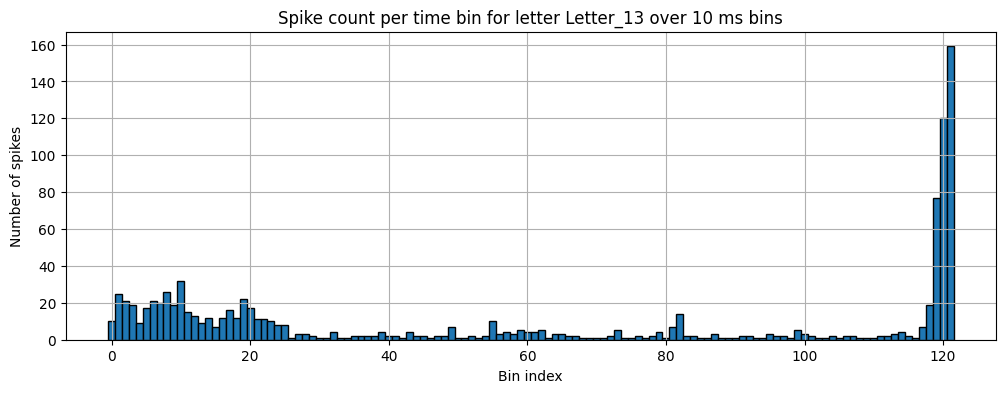

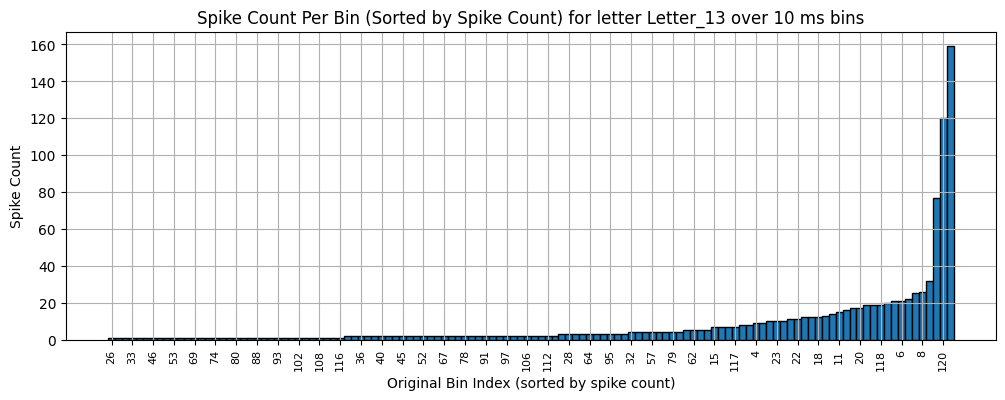


===== Letter Letter_14 =====
Bin starting at 18050ms: 15 coordinates
  Sample coords: [{'timestamp': 18059, 'x': 463, 'y': 224}, {'timestamp': 18059, 'x': 474, 'y': 368}, {'timestamp': 18059, 'x': 472, 'y': 230}]
Bin starting at 18060ms: 208 coordinates
  Sample coords: [{'timestamp': 18060, 'x': 466, 'y': 234}, {'timestamp': 18060, 'x': 477, 'y': 237}, {'timestamp': 18060, 'x': 476, 'y': 222}]
Bin starting at 18070ms: 239 coordinates
  Sample coords: [{'timestamp': 18070, 'x': 460, 'y': 363}, {'timestamp': 18070, 'x': 479, 'y': 362}, {'timestamp': 18070, 'x': 479, 'y': 346}]
Bin starting at 18080ms: 262 coordinates
  Sample coords: [{'timestamp': 18080, 'x': 465, 'y': 232}, {'timestamp': 18080, 'x': 453, 'y': 212}, {'timestamp': 18080, 'x': 454, 'y': 214}]
Bin starting at 18090ms: 200 coordinates
  Sample coords: [{'timestamp': 18090, 'x': 472, 'y': 346}, {'timestamp': 18090, 'x': 460, 'y': 232}, {'timestamp': 18090, 'x': 461, 'y': 235}]
Bin 0: 15 Events
Bin 1: 208 Events
Bin 2: 239 

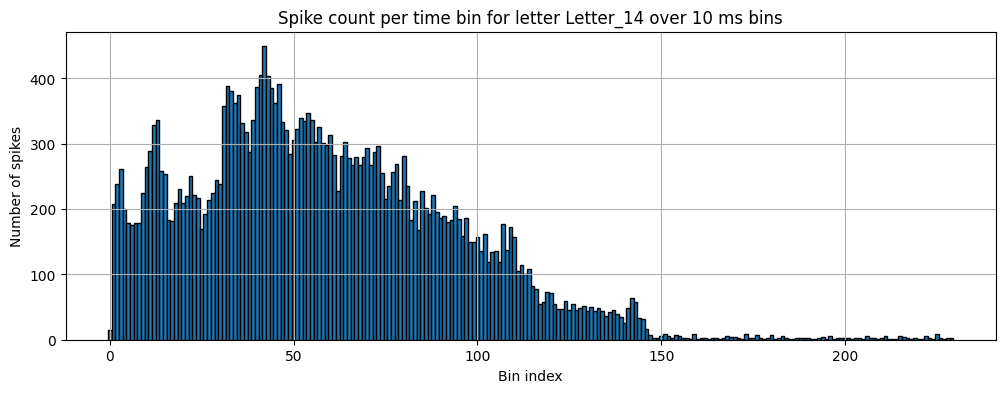

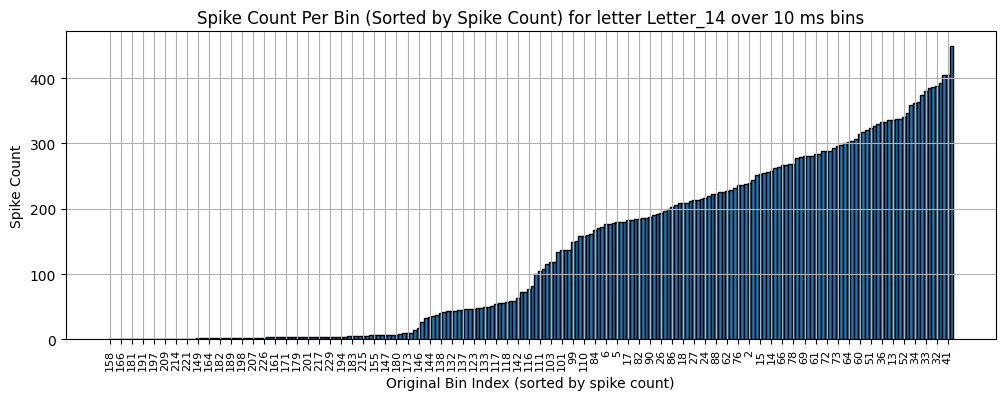


===== Letter Letter_15 =====
Bin starting at 20700ms: 8 coordinates
  Sample coords: [{'timestamp': 20703, 'x': 427, 'y': 160}, {'timestamp': 20705, 'x': 71, 'y': 577}, {'timestamp': 20706, 'x': 427, 'y': 160}]
Bin starting at 20710ms: 4 coordinates
  Sample coords: [{'timestamp': 20710, 'x': 71, 'y': 577}, {'timestamp': 20711, 'x': 427, 'y': 160}, {'timestamp': 20712, 'x': 71, 'y': 577}]
Bin starting at 20740ms: 4 coordinates
  Sample coords: [{'timestamp': 20745, 'x': 427, 'y': 160}, {'timestamp': 20746, 'x': 427, 'y': 160}, {'timestamp': 20749, 'x': 428, 'y': 160}]
Bin starting at 20750ms: 2 coordinates
  Sample coords: [{'timestamp': 20750, 'x': 192, 'y': 64}, {'timestamp': 20753, 'x': 427, 'y': 160}]
Bin starting at 20760ms: 1 coordinates
  Sample coords: [{'timestamp': 20767, 'x': 427, 'y': 160}]
Bin 0: 8 Events
Bin 1: 4 Events
Bin 2: 4 Events
Bin 3: 2 Events
Bin 4: 1 Events
Bin 5: 6 Events
Bin 6: 5 Events
Bin 7: 1 Events
Bin 8: 6 Events
Bin 9: 32 Events
Bin 10: 87 Events
Bin 11

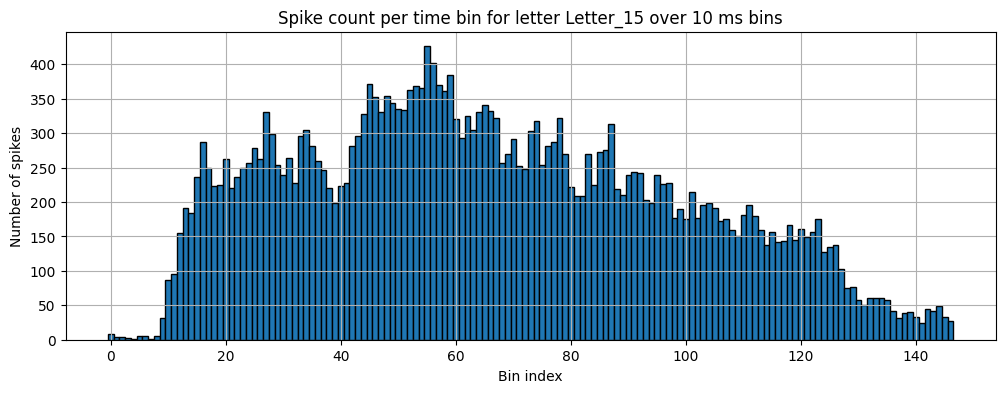

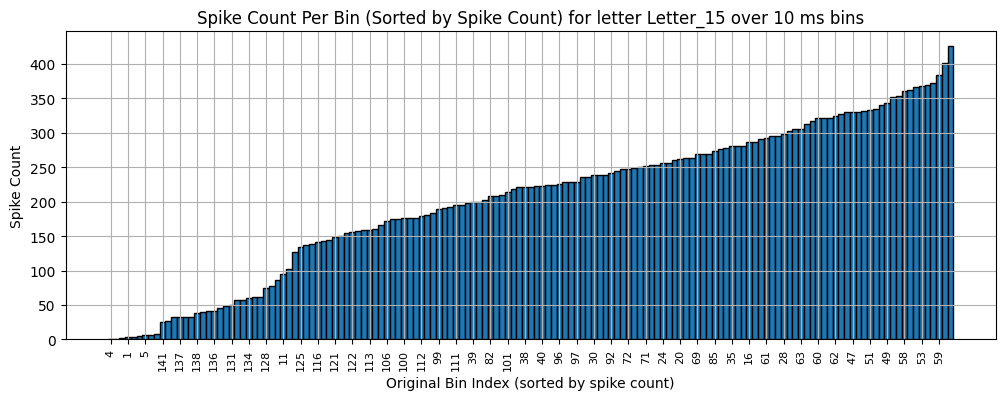


===== Letter Letter_16 =====
Bin starting at 22240ms: 12 coordinates
  Sample coords: [{'timestamp': 22246, 'x': 47, 'y': 208}, {'timestamp': 22246, 'x': 43, 'y': 205}, {'timestamp': 22247, 'x': 66, 'y': 200}]
Bin starting at 22250ms: 32 coordinates
  Sample coords: [{'timestamp': 22250, 'x': 43, 'y': 205}, {'timestamp': 22251, 'x': 60, 'y': 214}, {'timestamp': 22251, 'x': 57, 'y': 206}]
Bin starting at 22260ms: 33 coordinates
  Sample coords: [{'timestamp': 22260, 'x': 50, 'y': 210}, {'timestamp': 22260, 'x': 49, 'y': 202}, {'timestamp': 22260, 'x': 48, 'y': 201}]
Bin starting at 22270ms: 33 coordinates
  Sample coords: [{'timestamp': 22270, 'x': 35, 'y': 205}, {'timestamp': 22270, 'x': 40, 'y': 225}, {'timestamp': 22270, 'x': 51, 'y': 212}]
Bin starting at 22280ms: 42 coordinates
  Sample coords: [{'timestamp': 22280, 'x': 50, 'y': 206}, {'timestamp': 22280, 'x': 42, 'y': 208}, {'timestamp': 22280, 'x': 41, 'y': 206}]
Bin 0: 12 Events
Bin 1: 32 Events
Bin 2: 33 Events
Bin 3: 33 Even

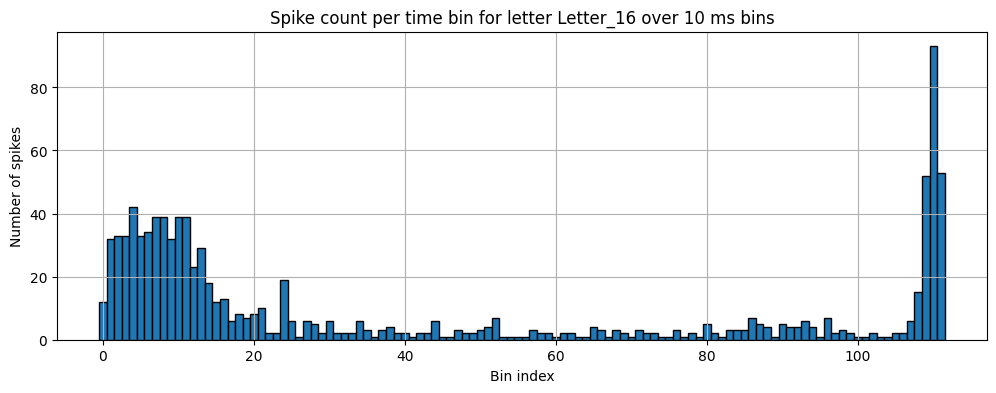

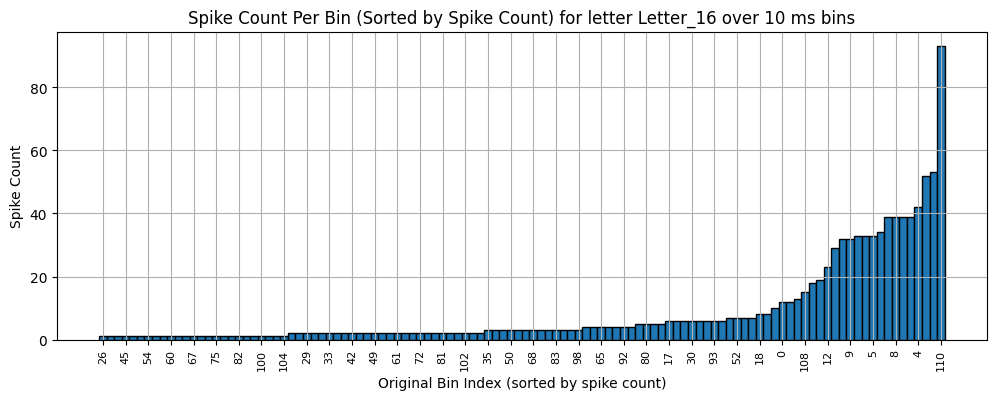


===== Letter Letter_17 =====
Bin starting at 23740ms: 32 coordinates
  Sample coords: [{'timestamp': 23746, 'x': 467, 'y': 216}, {'timestamp': 23746, 'x': 471, 'y': 203}, {'timestamp': 23746, 'x': 475, 'y': 219}]
Bin starting at 23750ms: 139 coordinates
  Sample coords: [{'timestamp': 23750, 'x': 459, 'y': 201}, {'timestamp': 23750, 'x': 468, 'y': 203}, {'timestamp': 23750, 'x': 466, 'y': 207}]
Bin starting at 23760ms: 130 coordinates
  Sample coords: [{'timestamp': 23760, 'x': 478, 'y': 196}, {'timestamp': 23760, 'x': 474, 'y': 202}, {'timestamp': 23760, 'x': 473, 'y': 210}]
Bin starting at 23770ms: 124 coordinates
  Sample coords: [{'timestamp': 23770, 'x': 464, 'y': 209}, {'timestamp': 23770, 'x': 463, 'y': 230}, {'timestamp': 23770, 'x': 460, 'y': 208}]
Bin starting at 23780ms: 108 coordinates
  Sample coords: [{'timestamp': 23780, 'x': 470, 'y': 222}, {'timestamp': 23780, 'x': 452, 'y': 209}, {'timestamp': 23780, 'x': 454, 'y': 217}]
Bin 0: 32 Events
Bin 1: 139 Events
Bin 2: 130 

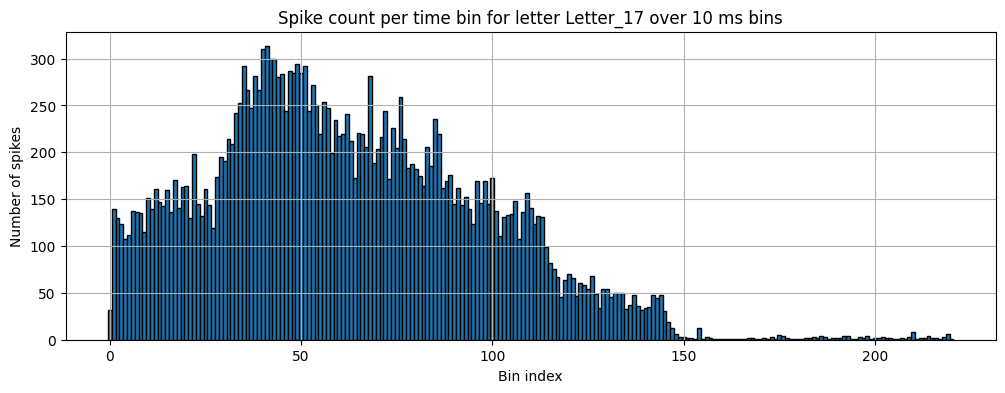

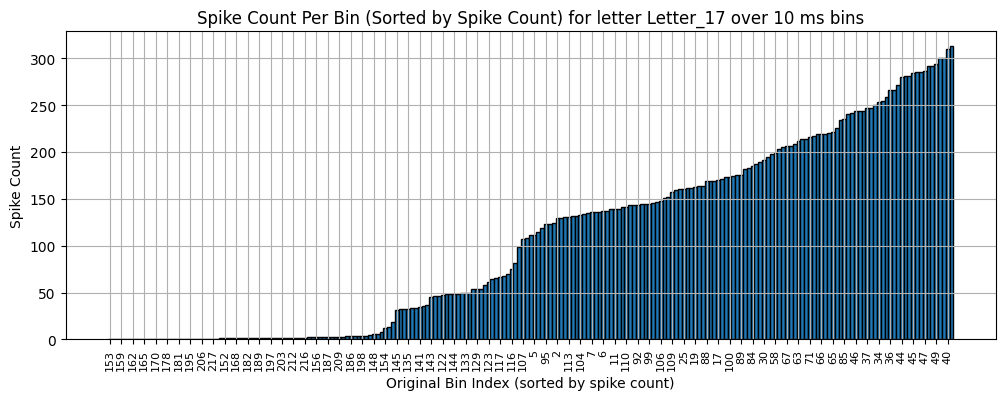

In [29]:
import networkx as nx


'''================== SEGMENT INTO LETTERS USING CENTROID SHIFT =================='''

segment_threshold = 50  # adjust as needed
bin_duration = 10 #ms
window = 1000
segments = []
current_segment = []
centroids = []
graph_by_letter = {}

for i in range(0, len(df_sorted), window):
    chunk = df_sorted.iloc[i:i+window]
    if chunk.empty:
        continue

    cx = chunk['x'].mean()
    cy = chunk['y'].mean()
    centroids.append((cx, cy))

    if len(centroids) > 1:
        dist = np.linalg.norm(np.array(centroids[-1]) - np.array(centroids[-2]))
        if dist > segment_threshold:
            segments.append(pd.DataFrame(current_segment))
            current_segment = []

    current_segment.extend(chunk.to_dict('records'))

if current_segment:
    segments.append(pd.DataFrame(current_segment))

'''================= LABEL LETTERS =================='''

braille_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
labels = braille_labels[:len(segments)]


'''=================== BIN EACH LETTER INDIVIDUALLY =================='''

for i, segment_df in enumerate(segments):
    label = labels[i] if i < len(labels) else f"Letter_{i}"
    print(f"\n===== Letter {label} =====")

    time_bins = defaultdict(list)
    for _, row in segment_df.iterrows():
        bin_start = (row['timestamp'] // bin_duration) * bin_duration
        time_bins[bin_start].append({
            'timestamp': row['timestamp'],
            'x': row['x'],
            'y': row['y']
        })

    # Show first 5 time bins for each letter
    for j, (bin_start, coords_list) in enumerate(sorted(time_bins.items())):
        print(f"Bin starting at {bin_start}ms: {len(coords_list)} coordinates")
        print(f"  Sample coords: {coords_list[:3]}")
        if j >= 4:
            break

    #extract features from binned data
    #extract events
    node_features = np.array([len(events) for bin_start, events in sorted(time_bins.items())]).reshape(-1, 1)

    for i in range(len(node_features)):
        print(f"Bin {i}: {node_features[i][0]} Events")

    event_counts = node_features.flatten()
    bins = np.arange(len(event_counts))

    #record graph from letter to dictionary
    G = nx.Graph()
    G.add_nodes_from(bins)
    
    graph_by_letter[label] = {
    "graph": G, #record graph data
    "bins": time_bins, #record bin data
    "event_counts": event_counts, #record event counts
    "bin_duration": bin_duration #record the current bin duration <------ added recently - need to look into
    }

    '''==================== PLOT HISTOGRAMS ===================='''

    '''Bin ordered:'''
    plt.figure(figsize = (12, 4))
    plt.bar(np.arange(len(event_counts)), event_counts, width = 1.0, edgecolor = 'black')
    plt.xlabel('Bin index')
    plt.ylabel('Number of spikes')
    plt.title(f'Spike count per time bin for letter {label} over {bin_duration} ms bins')
    plt.grid(True)
    plt.show()

    '''Spike count ordered:'''
    #pair each bin index with corresponding spike count (excluding 0 events)
    bin_spike_pairs = [(i, count) for i, count in enumerate(event_counts) if count > 0]

    #sorted by spike count:
    sorted_pairs = sorted(bin_spike_pairs, key = lambda x: x[1])  # (bin_index, spike_count)

    #unpack into separate lists
    sorted_bins, sorted_counts = zip(*sorted_pairs)

    plt.figure(figsize=(12, 4))
    plt.bar(np.arange(len(sorted_counts)), sorted_counts, tick_label = sorted_bins, width = 1.0, edgecolor = 'black')

    #space out x ticks (every 3 bars)
    xtick_spacing = 3
    plt.xticks(
    ticks = np.arange(0, len(sorted_bins), xtick_spacing),
    labels = [sorted_bins[i] for i in range(0, len(sorted_bins), xtick_spacing)],
    rotation = 90,
    fontsize = 8
    )

    plt.xlabel('Original Bin Index (sorted by spike count)')
    plt.ylabel('Spike Count')
    plt.title(f'Spike Count Per Bin (Sorted by Spike Count) for letter {label} over {bin_duration} ms bins')
    plt.grid(True)
    plt.show()


In [ ]:
'''=========================== UNWEIGHTED ==========================='''

#---------------------------- SPIKE-COUNT BASED, UNDIRECTED -----------------------------
def UNDIR_SPIKE_COUNT(event_counts, base_graph, time_bins, bin_duration):

  '''Edges connect bins with identical spike counts'''

  #Adjacent - bins with identical spike counts
  title = "Adjacent bins - identical spike counts"

  G = base_graph.copy() #reuse existing nodes

  for i in range(len(event_counts)):
    for j in range(i + 1, len(event_counts)):
      if event_counts[i] == event_counts[j]:
          G.add_edge(i, j, weight = 0.5) #identical spike counts

  return G, title, False #not weighted



#---------------------------- TIME BASED, DIRECTED -----------------------------
def DIR_TIME(event_counts, base_graph, time_bins, bin_duration):
    
  '''Edges connect time bins at a chronological order'''

  title = "Adjacent bins - directed for succeeding time bins"
    
    #convert to a directed graph with same nodes
  G = nx.DiGraph()
  G.add_nodes_from(base_graph.nodes())  #reuse existing nodes

    #connect each time bin to next one in sequence
  for i in range(len(time_bins) - 1):
      G.add_edge(i, i + 1, weight = 1)

  return G, title, False #not weighted

'''============================ WEIGHTED ============================='''

#-------------------------- SPIKE-COUNT BASED, UNDIRECTED ------------------------
def UNDIR_SPIKE_COUNT_W(event_counts, base_graph, time_bins, bin_duration):

  '''Edges connect bins with identical spike counts - the more common a spike count is across the bins - the higher its edge's weight.'''

  #Adjacent - identical spike counts
  #Greater weight - the more identical counts the larger the weight 

  title = "Adjacent bins - identical spike counts, shorter edges = more bins identical counts"
  weighted = True

  G = base_graph.copy() #reuse existing nodes

  matching_pairs = [
  (i,j)
  for i, j in combinations(range(len(event_counts)), 2)
    if event_counts[i] == event_counts[j]
  ]

  #total number of matching pairs
  total_matches = len(matching_pairs)

  if total_matches > 0:
    weight = 1 / total_matches #minimizing weight for shorter edges
  else: 
       weight = float('inf') #ignore it (really large number)

  for i, j in matching_pairs:
       G.add_edge(i, j, weight = weight) 

  return G, title, True #weighted

#-------------------------- SPIKE-COUNT BASED, DIRECTED ------------------------
def DIR_SPIKE_COUNT_W(event_counts, base_graph, time_bins, bin_duration):

  '''Edges connect bins with increasing spike count - WEIGHTED - shorter edges for for identical spike counts'''

  #Adjacent - bins with increasing spike counts + weights for identical counts
  title = "Adjacent bins - directed for increasing spike counts"
  
  #convert to a directed graph with same nodes
  G = nx.DiGraph()
  G.add_nodes_from(base_graph.nodes())  #reuse existing nodes

  for i in range(len(event_counts)):
    for j in range(i + 1, len(event_counts)):
      if event_counts[i] < event_counts[j]: #any increase
        if event_counts[i] + 1 == event_counts[j]:
            G.add_edge(i, j, weight = 0.3) #shorter edge for a +1 increment
        else:
           G.add_edge(i,j, weight = 1) #normal edge for any other increase
      elif event_counts[i] == event_counts[j]:
            G.add_edge(i, j, weight = 0.5) #shorter edge for identical spike counts

  return G, title, True #weighted

In [31]:
'''============================================== State Machine ====================================================='''

from torch_geometric.utils import from_networkx
import torch

def graph_gen(G, title, weighted):
  
  '''Graph generation function'''
  #if weighted add weight to edges

  #force-directed layout for clarity (not a perfect circle)
  pos = nx.spring_layout(G, seed=42, k = 0.5)

  nx.draw(
    G,
    pos = pos,
    with_labels=True,
    node_color='lightsteelblue',
    node_size=50,
    font_size=6,
    width=1.0,
    edge_color='gray',)

  if weighted:
   edge_labels = nx.get_edge_attributes(G, 'weight')
   nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 5)

  plt.margins(0.1)
  plt.title(title)
  plt.show()

#available states:
states = {
    'undir_spike_count': UNDIR_SPIKE_COUNT,
    'dir_time': DIR_TIME,
    'dir_spike_count_w': DIR_SPIKE_COUNT_W,
    'undir_spike_count_w': UNDIR_SPIKE_COUNT_W
}

def nx2pyg(G, label = None):

  '''Format conversion function from network x to python geometric:'''

  #setting default values if node lacks features(x) or positions(pos)
  for node in G.nodes:
    if 'x' not in G.nodes[node]:
      G.nodes[node]['x'] = [1] #default
    if 'pos' not in G.nodes[node]:
      G.nodes[node]['pos'] = [0, 0] #default

  #setting default edge attributes if edge weights or time are missing  
  for u, v, attr in G.edges(data = True):
    if 'weight' not in attr:
      attr['weight'] = 1
    if 'time' not in attr:
      attr['time'] = 0

  #converts networkx graph into torch geometric data object
  #convert all nodes and edges into pytorch tensors
  data = from_networkx(G)

  #combine edge attributes: weight and time into 2D tensor per edge: [weight,time]
  if G.number_of_edges() > 0:
    data.edge_attr = torch.stack([
      data.weight,
      data.time
    ], dim = 1) if 'time' in data else data.weight.unsqueeze(1) #squeeze ensures edge_attr is 2D even if one attribute is missing. 
  else: #added else so it doesnt always overwrites edge attributes
    #handle empty graphs
    data.edge_attr = torch.empty((0, 2), dtype = torch.float) #empty edge attributes for edge-less graphs.

  #convert each node's x and pos attributes into pytorch tensors:
  data.x = torch.tensor([G.nodes[n]['x'] for n in G.nodes],dtype = torch.float )
  data.pos = torch.tensor([G.nodes[n]['pos'] for n in G.nodes],dtype = torch.float )

  #ground truth for model training
  if label is not None:
    data.y = torch.tensor([label], dtype = torch.long) #ground truth for training - y label for loss function.

  return data

'''
def visualizer(letter_dictionary, letter = None):
    
  #visualizes, stores and converts graphs generated by the generator

  #if specific letter requested, process only that letter, else all
  letters_to_process = [letter] if letter in letter_dictionary else letter_dictionary.keys()  
    
  for letter_key in letters_to_process:
    data = letter_dictionary[letter_key]
    print(f"Running all graph states for letter {letter}...\n")
      
    event_counts = data['event_counts']
    time_bins = data['bins']
    bin_duration = data['bin_duration']
    base_graph = data['graph']

    #store generated graphs for model:
    data['graph_variants'] = {} #for graph variants
    data['pyg_graphs'] = {} #for pyg graphs

    
    for name, func in states.items():
      G, title, weighted = func(event_counts, base_graph, time_bins, bin_duration)
      print(f"Visualizing: {title}")
      graph_gen(G, title = f"{title} ({letter_key})", weighted = weighted)

      data['graph_variants'][name] = G #save graph in dictionary
      
      #convert and store pyg graph
      pyg_graph = nx2pyg(G, label = None)  #use label if available
      data['pyg_graphs'][name] = pyg_graph

  pyg_data = {letter: data['pyg_graphs'] for letter, data in letter_dictionary.items() if 'pyg_graphs' in data}
  
  # Set save name to match the .npy file name with "_pyg_graphs" ending
  save_name = os.path.basename(file_path).replace('.npy', '_pyg_graphs.pt')
  torch.save(pyg_data, save_name)
  
  print(f"Saved PyG graphs for letters: {list(pyg_data.keys())}")

#i could also print the dictionary information for specific letter instead if im lazy
'''

'\ndef visualizer(letter_dictionary, letter = None):\n    \n  #visualizes, stores and converts graphs generated by the generator\n\n  #if specific letter requested, process only that letter, else all\n  letters_to_process = [letter] if letter in letter_dictionary else letter_dictionary.keys()  \n    \n  for letter_key in letters_to_process:\n    data = letter_dictionary[letter_key]\n    print(f"Running all graph states for letter {letter}...\n")\n      \n    event_counts = data[\'event_counts\']\n    time_bins = data[\'bins\']\n    bin_duration = data[\'bin_duration\']\n    base_graph = data[\'graph\']\n\n    #store generated graphs for model:\n    data[\'graph_variants\'] = {} #for graph variants\n    data[\'pyg_graphs\'] = {} #for pyg graphs\n\n    \n    for name, func in states.items():\n      G, title, weighted = func(event_counts, base_graph, time_bins, bin_duration)\n      print(f"Visualizing: {title}")\n      graph_gen(G, title = f"{title} ({letter_key})", weighted = weighted)\n

In [32]:
def generate_and_save_graphs(letter_dictionary, file_path, letter=None):
    """generates graphs and converts to PyG format - saves for model2 with minimal changes"""
    
    print(f"DEBUG: Starting gen_and_save_graphs with file_path: {file_path}")
    print(f"DEBUG: letter_dictionary keys: {list(letter_dictionary.keys())}")
    
    # if specific letter requested, process only that letter, else all
    letters_to_process = [letter] if letter in letter_dictionary else letter_dictionary.keys()  
    print(f"DEBUG: letters_to_process: {list(letters_to_process)}")
      
    for letter_key in letters_to_process:
        data = letter_dictionary[letter_key]
        print(f"Processing graphs for letter {letter_key}...\n")
          
        event_counts = data['event_counts']
        time_bins = data['bins']
        bin_duration = data['bin_duration']
        base_graph = data['graph']

        # store generated graphs for model:
        data['graph_variants'] = {}  # for graph variants
        data['pyg_graphs'] = {}      # for pyg graphs
        data['graph_info'] = {}      # store title and weighted info for visualization

        for name, func in states.items():
            G, title, weighted = func(event_counts, base_graph, time_bins, bin_duration)
            print(f"Generated: {title}")

            data['graph_variants'][name] = G  # save graph in dictionary
            data['graph_info'][name] = {'title': title, 'weighted': weighted}  # save info for visualization
            
            # convert and store pyg graph
            pyg_graph = nx2pyg(G, label=None)  # use label if available
            data['pyg_graphs'][name] = pyg_graph

    print(f"DEBUG: Finished generating graphs. Starting save process...")

    # CHANGE 1: CORRECTED Split configuration following supervisor's instructions
    # Each split contains all Braille letters (A–J) under both LED ON and LED OFF
    # Proportions: 70% train, 15% val, 15% test
    split_config = {
        'train': {
            'led_on': ['A','B','C','D','E','F','G','H','I','J'],
            'led_off': ['A','B','C','D','E','F','G','H','I','J']
        },
        'val': {
            'led_on': ['A','B','C','D','E','F','G','H','I','J'],
            'led_off': ['A','B','C','D','E','F','G','H','I','J']
        },
        'test': {
            'led_on': ['A','B','C','D','E','F','G','H','I','J'],
            'led_off': ['A','B','C','D','E','F','G','H','I','J']
        }
    }
    # Note: The actual 70/15/15 split is handled during dataset construction
    # This config just states that all letters appear in all splits.

    # CHANGE 2: Create directories next to your .npy file
    data_dir = os.path.dirname(file_path)
    for s in ['train', 'val', 'test']:
        os.makedirs(os.path.join(data_dir, f'data/{s}/processed'), exist_ok=True)
    print(f"DEBUG: Directories created successfully")

    # Extract info from filename
    file_base = os.path.basename(file_path)
    
    # Extract trial number
    if 'trial_' in file_base:
        trial_num = file_base.split('trial_')[1].split('_')[0]
    else:
        trial_num = '1'  # default
    
    is_led_on = '_on.npy' in file_base
    led_status = 'on' if is_led_on else 'off'
    print(f"DEBUG: file_base = {file_base}")
    print(f"DEBUG: trial_num = {trial_num}, led_status = {led_status}")

    # CHANGE 3: Always process since all letters are in all splits now
    print(f"DEBUG: Starting to save individual graphs...")
    
    # CHANGE 4: Count samples per graph type for 70-15-15 split
    graph_type_counters = {graph_type: 1 for graph_type in states.keys()}
    
    for letter_key, data in letter_dictionary.items():
        print(f"DEBUG: Processing letter_key: {letter_key}")
        if 'pyg_graphs' in data:
            print(f"DEBUG: Found pyg_graphs for {letter_key}, graph types: {list(data['pyg_graphs'].keys())}")
            for state_name, pyg_graph in data['pyg_graphs'].items():
                print(f"DEBUG: Processing graph {state_name} for letter {letter_key}")
                
                # Handle both single letters (A, B, C) and longer keys (Letter_10, etc.)
                if len(letter_key) == 1 and letter_key.isalpha():
                    label_value = ord(letter_key) - ord('A')
                else:
                    if letter_key.startswith('Letter_'):
                        label_value = int(letter_key.split('_')[1])
                    else:
                        label_value = 0
                
                print(f"DEBUG: letter_key='{letter_key}', label_value={label_value}")
                pyg_graph.y = torch.tensor([label_value], dtype=torch.long)
                
                # CHANGE 5: Implement 70-15-15 split based on sample count
                current_count = graph_type_counters[state_name]
                if current_count <= int(0.7 * 200):  # First 70% go to train (assuming ~200 total samples)
                    split = 'train'
                elif current_count <= int(0.85 * 200):  # Next 15% go to val
                    split = 'val'
                else:  # Last 15% go to test
                    split = 'test'
                
                # CHANGE 6: Use your naming convention and save location
                save_dir = os.path.join(data_dir, f'data/{split}/processed')
                filename = f"trial_{trial_num}_events_{led_status}_{letter_key}_{state_name}.pt"
                save_path = os.path.join(save_dir, filename)
                print(f"DEBUG: Attempting to save to: {save_path}")
                
                torch.save(pyg_graph, save_path)
                print(f"  ✓ Saved {state_name} graph for letter {letter_key} as {filename}")
                graph_type_counters[state_name] += 1
        else:
            print(f"DEBUG: No pyg_graphs found for {letter_key}")
    
    # CHANGE 7: Update final print statements
    total_saved = sum(counter - 1 for counter in graph_type_counters.values())
    print(f"DEBUG: Finished saving. Total samples saved: {total_saved}")
    for graph_type, counter in graph_type_counters.items():
        print(f"Saved {counter-1} samples for {graph_type}")
    print(f"Files saved to: {os.path.join(data_dir, 'data/')}")
    print(f"Format: trial_{trial_num}_events_{led_status}_[LETTER]_[GRAPH_TYPE].pt")

def visualize_graphs(letter_dictionary, letter = None):
    
    '''visualizes already generated graphs'''
    
    #if specific letter requested, process only that letter, else all
    letters_to_process = [letter] if letter in letter_dictionary else letter_dictionary.keys()  
      
    for letter_key in letters_to_process:
        data = letter_dictionary[letter_key]
        
        if 'graph_variants' in data and 'graph_info' in data:
            print(f"Visualizing graphs for letter {letter_key}...\n")
            for name in data['graph_variants'].keys():
                G = data['graph_variants'][name]
                title = data['graph_info'][name]['title']
                weighted = data['graph_info'][name]['weighted']
                
                print(f"Visualizing: {title}")
                graph_gen(G, title = f"{title} ({letter_key})", weighted = weighted)
        else:
            print(f"No graphs found for letter {letter_key}. Run generate_and_save_graphs() first.")

In [33]:
generate_and_save_graphs(graph_by_letter, file_path)


DEBUG: Starting gen_and_save_graphs with file_path: C:/Users/Teamaerosal/Desktop/Dissertation DUE 29TH AUG/Essentials for Braille Project/07_03_collect_10_row1_1/events/taps_trial_0_pose_0_events_off.npy
DEBUG: letter_dictionary keys: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'Letter_10', 'Letter_11', 'Letter_12', 'Letter_13', 'Letter_14', 'Letter_15', 'Letter_16', 'Letter_17']
DEBUG: letters_to_process: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'Letter_10', 'Letter_11', 'Letter_12', 'Letter_13', 'Letter_14', 'Letter_15', 'Letter_16', 'Letter_17']
Processing graphs for letter A...

Generated: Adjacent bins - identical spike counts
Generated: Adjacent bins - directed for succeeding time bins
Generated: Adjacent bins - directed for increasing spike counts
Generated: Adjacent bins - identical spike counts, shorter edges = more bins identical counts
Processing graphs for letter B...

Generated: Adjacent bins - identical spike counts
Generated: Adjacent bins - directed for

In [34]:
# TEST: Verify graphs are valid after generation
def test_generated_graphs():
    """Test that your generated graphs are valid for model2_training"""
    
    # Find a sample file that was just generated
    data_dir = os.path.dirname(file_path)
    test_dirs = [
        os.path.join(data_dir, 'data/train/processed'),
        os.path.join(data_dir, 'data/val/processed'), 
        os.path.join(data_dir, 'data/test/processed')
    ]
    
    test_file = None
    for test_dir in test_dirs:
        if os.path.exists(test_dir):
            files = [f for f in os.listdir(test_dir) if f.endswith('.pt')]
            if files:
                test_file = os.path.join(test_dir, files[0])
                break
    
    if not test_file:
        print("❌ No generated graph files found!")
        return False
    
    print(f"🔍 Testing graph: {os.path.basename(test_file)}")
    
    try:
        # Load the graph
        test_graph = torch.load(test_file)
        
        # Check all required attributes exist
        print(f"✅ Nodes: {test_graph.x.shape}")
        print(f"✅ Node positions: {test_graph.pos.shape}")
        print(f"✅ Edges: {test_graph.edge_index.shape}")  
        print(f"✅ Edge attributes: {test_graph.edge_attr.shape}")
        print(f"✅ Labels: {test_graph.y} (dtype: {test_graph.y.dtype})")
        
        # Validate data types
        assert test_graph.y.dtype == torch.int64, f"❌ Labels should be torch.int64, got {test_graph.y.dtype}"
        assert test_graph.x.dtype == torch.float32, f"❌ Node features should be torch.float32, got {test_graph.x.dtype}"
        
        # Check edge attributes shape
        if test_graph.edge_index.shape[1] > 0:  # If graph has edges
            expected_edge_attrs = test_graph.edge_index.shape[1]
            actual_edge_attrs = test_graph.edge_attr.shape[0]
            assert expected_edge_attrs == actual_edge_attrs, f"❌ Edge count mismatch: {expected_edge_attrs} vs {actual_edge_attrs}"
        
        print("🎉 SUCCESS: Graph is valid for model2_training!")
        return True
        
    except Exception as e:
        print(f"❌ ERROR: {e}")
        return False

# Run the test
test_generated_graphs()

🔍 Testing graph: trial_0_events_off_A_dir_spike_count_w.pt
❌ ERROR: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL torch_geometric.data.data.DataEdgeAttr was not an allowed global by default. Please use `torch.serialization.add_safe_globals([torch_geometric.data.data.DataEdgeAttr])` or the `torch.serialization.safe_globals([torch_geometric.data.data.DataEdgeAttr])` context manager to allowlist this global if you trust

False

Visualizing graphs for letter A...

Visualizing: Adjacent bins - identical spike counts


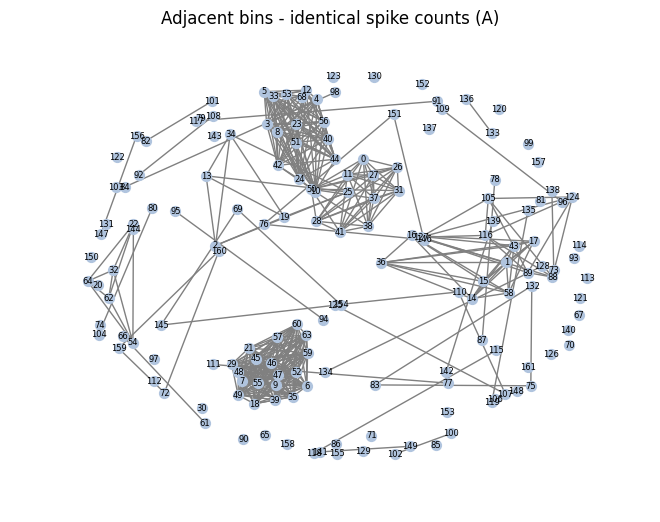

Visualizing: Adjacent bins - directed for succeeding time bins


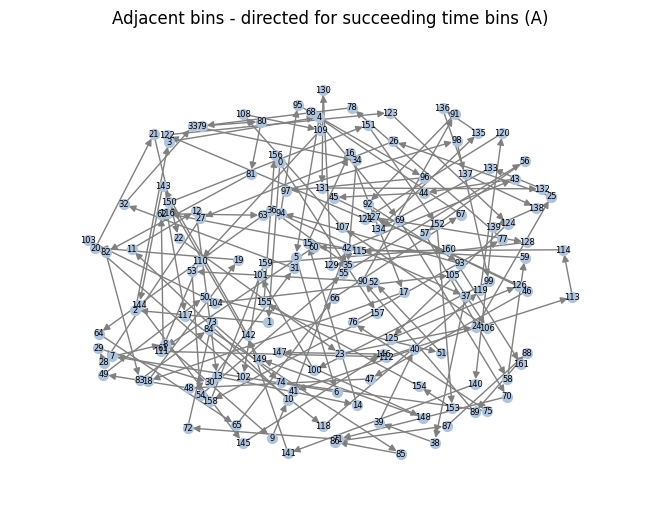

Visualizing: Adjacent bins - directed for increasing spike counts


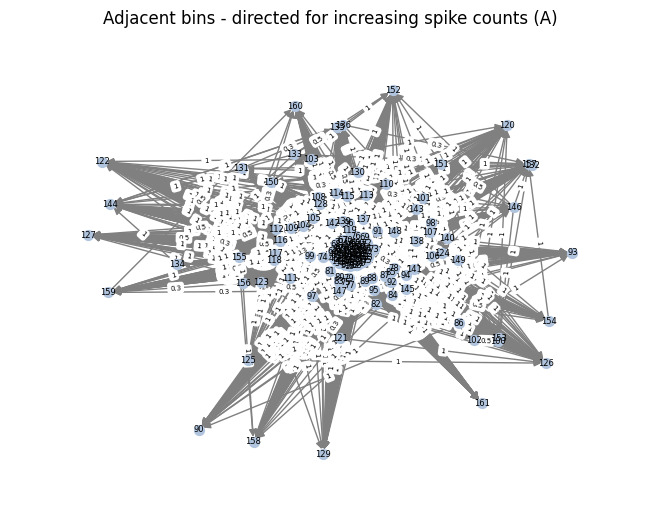

Visualizing: Adjacent bins - identical spike counts, shorter edges = more bins identical counts


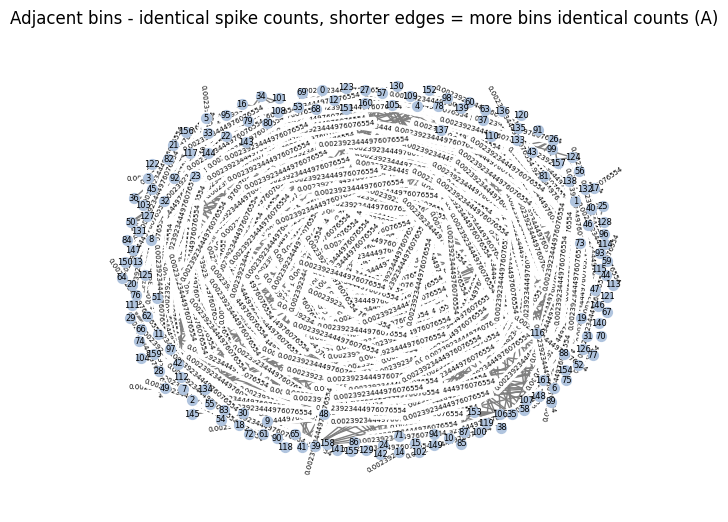

Visualizing graphs for letter B...

Visualizing: Adjacent bins - identical spike counts


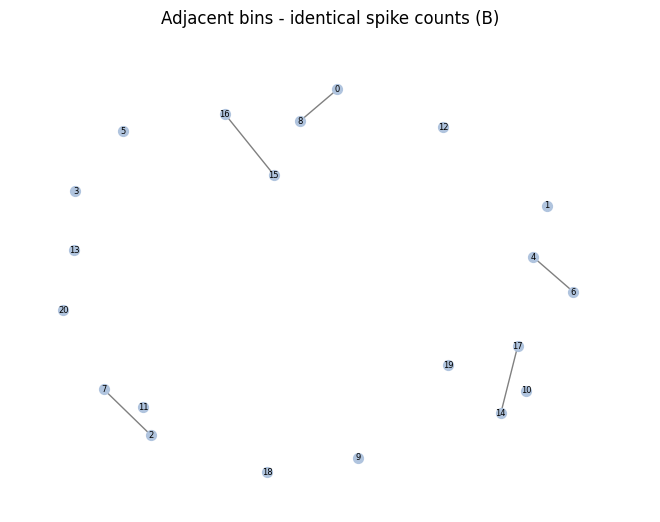

Visualizing: Adjacent bins - directed for succeeding time bins


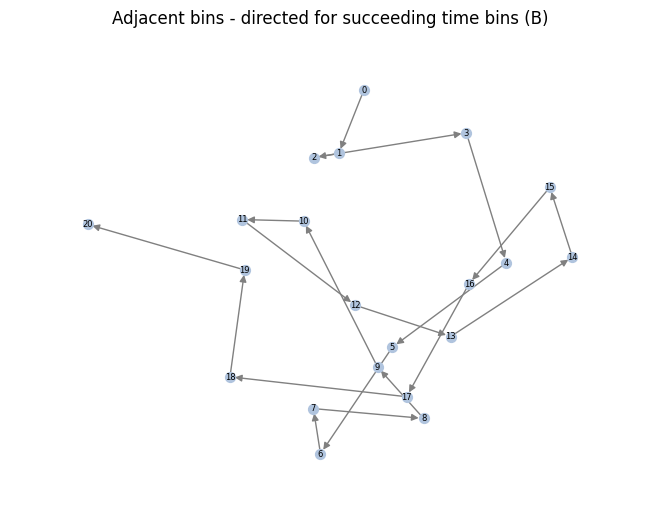

Visualizing: Adjacent bins - directed for increasing spike counts


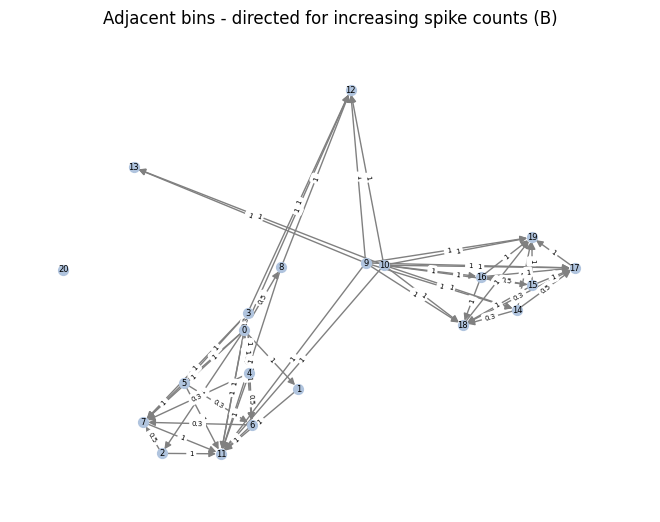

Visualizing: Adjacent bins - identical spike counts, shorter edges = more bins identical counts


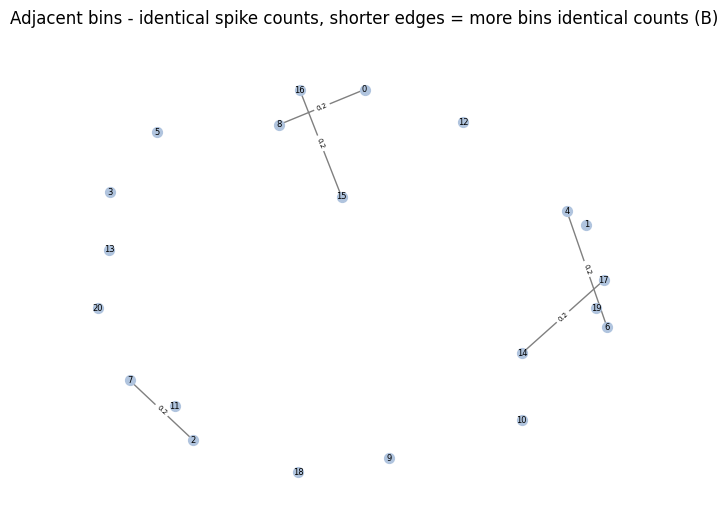

Visualizing graphs for letter C...

Visualizing: Adjacent bins - identical spike counts


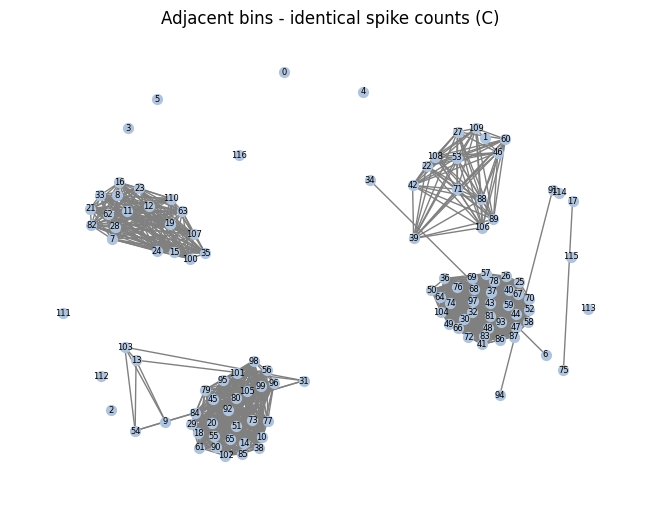

Visualizing: Adjacent bins - directed for succeeding time bins


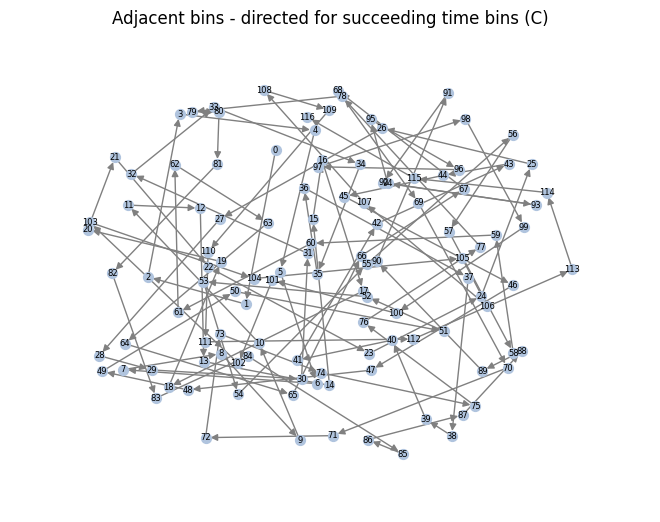

Visualizing: Adjacent bins - directed for increasing spike counts


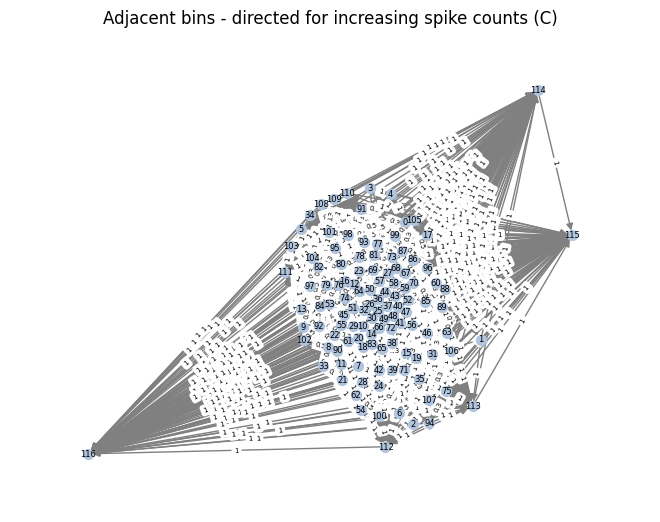

Visualizing: Adjacent bins - identical spike counts, shorter edges = more bins identical counts


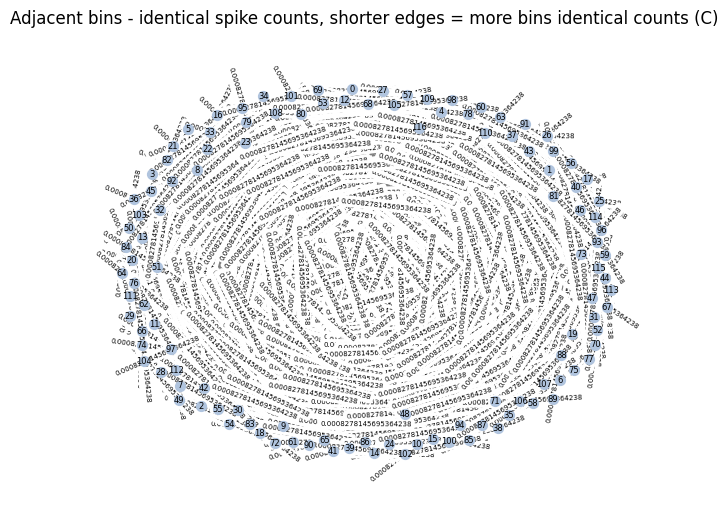

Visualizing graphs for letter D...

Visualizing: Adjacent bins - identical spike counts


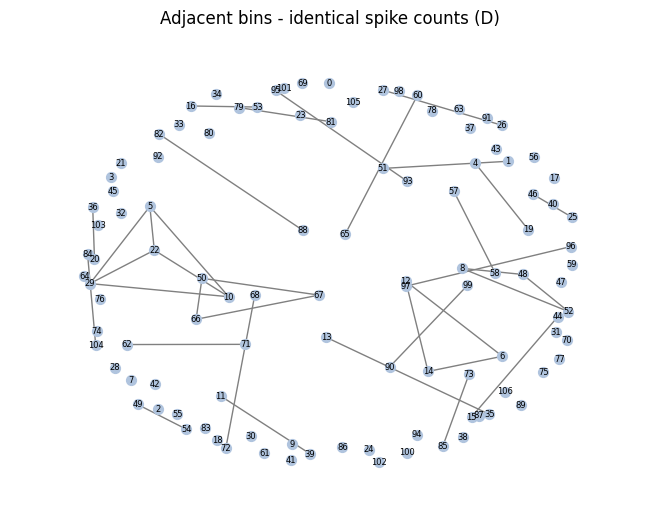

Visualizing: Adjacent bins - directed for succeeding time bins


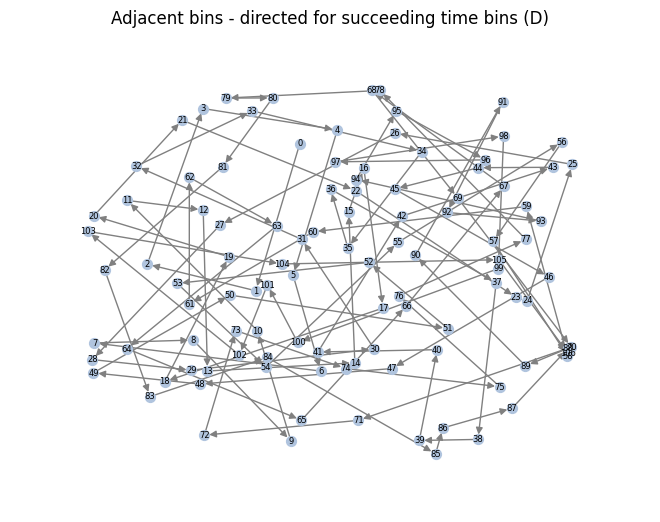

Visualizing: Adjacent bins - directed for increasing spike counts


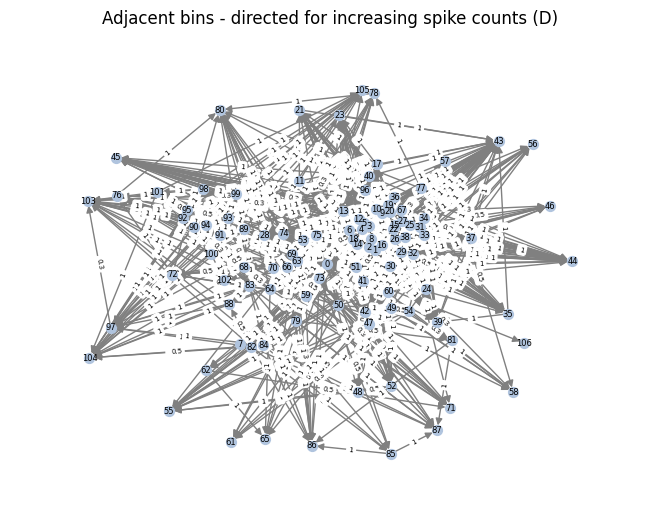

Visualizing: Adjacent bins - identical spike counts, shorter edges = more bins identical counts


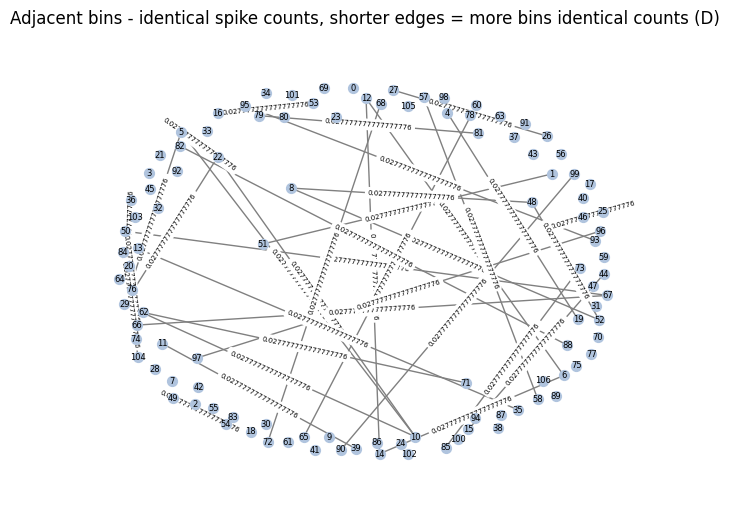

Visualizing graphs for letter E...

Visualizing: Adjacent bins - identical spike counts


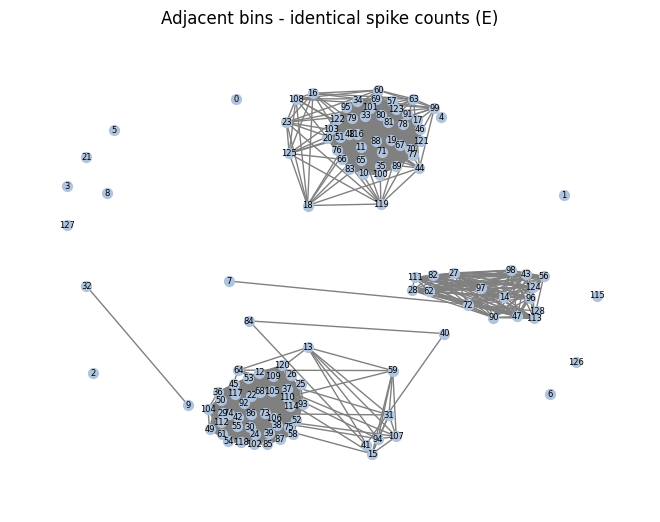

Visualizing: Adjacent bins - directed for succeeding time bins


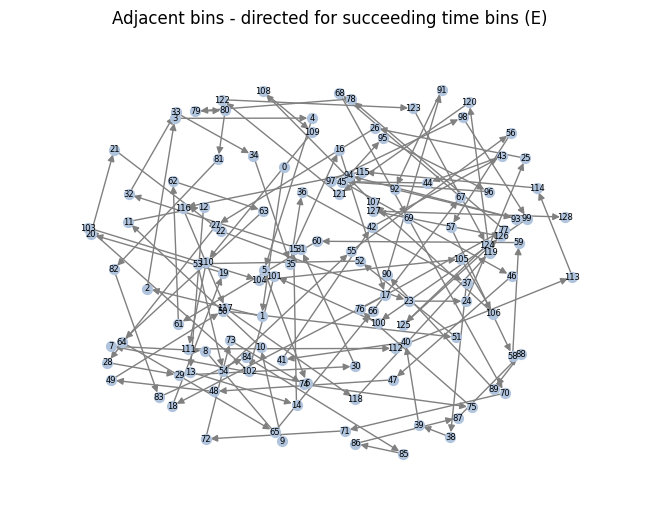

Visualizing: Adjacent bins - directed for increasing spike counts


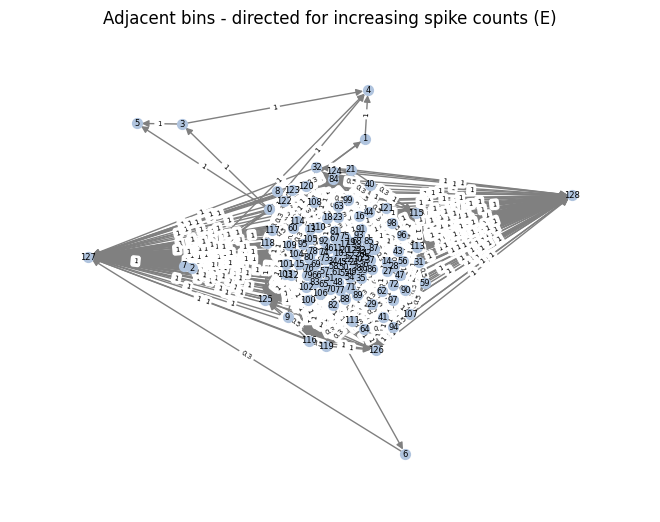

Visualizing: Adjacent bins - identical spike counts, shorter edges = more bins identical counts


In [ ]:
visualize_graphs(graph_by_letter)

Run the visualizer to visualize graphs and save them on system. 

In [ ]:
'''Visualize Graphs'''

#graph_visualizer(graph_by_letter, letter = "A") #specific letter
#visualizer(graph_by_letter) #all letters

'Visualize Graphs'